## Important librairies

In [1]:
### Important librairies
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
import seaborn as sns
from lxml import objectify
import math

#from pytrends.request import TrendReq
from wordcloud import WordCloud
#from ast import literal_eval

#Import data from wikidata.org
#from wikidata2df import wikidata2df

import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import os
import collections
from collections import Counter
import random

from PIL import Image


# Analysis of the lexical fields
from empath import Empath 
from IPython.display import Image
import re
import spacy
import plotly.express as px
import plotly.graph_objects as go

import ipywidgets as widgets


data_folder = './data/'

In [2]:
#Import empath 
lexicon = Empath()

## Create dataframes for analysis

### Import data frame of results

In [3]:
df_character_usa_summary_results = pd.read_csv('NLP/df_character_nlp.csv.zip', sep = ';', encoding = 'utf-8')
df_movie_usa_summary_results = pd.read_csv('NLP/df_movie_usa_summary_nlp.csv.zip' , sep = ';', encoding = 'utf-8')
df_movie_usa = pd.read_csv('df_movie_usa.csv')

### Constants

In [4]:
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010'] #decades period for following analyses
decades_index = [0,1,2,3,4,5,6,7] #index for decades
lexical_fields = list(lexicon.analyze([]).keys()) #categories of lexical fields 

### Add important features to the dataframes

In [5]:
#Add year of the movie
df_movie_usa['Year']=df_movie_usa['Movie_date'].apply(lambda x: str(x)[0:4])

In [6]:
#Add  decades columns
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['Movie_date']>decade[0:3]) & (df_movie_usa['Movie_date']<decade[5:8])].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [7]:
#Merge dataframes
df_character_usa_summary_results= df_character_usa_summary_results.merge( df_movie_usa[['Wikipedia_movie_ID','Year','Decade','RT average_x','TS score_x']],on='Wikipedia_movie_ID')

### Add a gender reference weighting column 

In each movie summary, the number of coreference counts the number quotations for each character. The weighting of a character is defined as the number of coreference dedicated to this character divided by the total number of coreferences in the summary. It is interesting to see the the evolution of female and male characters across decades.


In [8]:
df = df_character_usa_summary_results.copy()
total_coref = pd.Series(df.groupby('Wikipedia_movie_ID')['Coref_count'].agg('sum'),name='Total_coref') #count the total number of coreferences for each movie
total_coref.reset_index()
df = df.merge(total_coref,on='Wikipedia_movie_ID') 
df['Weighting'] = df['Coref_count'] / df['Total_coref'] #coref of the character divided by the total number of coref in the summary
df_character_usa_summary_results['Weighting'] = df['Weighting']

### Add a main genre column 

Each movies are assigned with several genres. We assume that the first cited genre is the main genre of the movie. From this, we exctract the main genre.

In [9]:
df1 = df_movie_usa.copy()
df1['Movie_genres_split'] = df1['Movie_genres'].apply(lambda x:  x.split("'")[1::2])
df1['Genre_unique'] = df1['Movie_genres_split'].apply(lambda x: x[0] if len(x)>0 else 'None') #First element of the list of genres
df_movie_usa['Main_genre'] = df1['Genre_unique']

### Show the dataframes

In [10]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,Year,Decade,Main_genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,2001,7,Thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,7,Mystery
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913,0,Short Film
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1938,0,Musical
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930,0,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,2000,7,Parody
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,1993,6,Thriller
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1946,1,Comedy film
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,118.0,0.0,0.0,NaN,NaN,NaN,NaN,2011,0,Drama


In [11]:
df_character_usa_summary_results

,Character_name,Freebase_character_ID,Actor_gender,Wikipedia_movie_ID,Coref_count,Main_actor,Adjectives,Verbs,Attributes,Year,Decade,RT average_x,TS score_x,Weighting
0,Ash Williams,/m/06_krl,M,3217,44,0,[],"['land', 'fight', 'grow', 'return', 'start', '...","['torment', 'king']",1992,6,6.9/10,73%,0.880000
1,Duke Henry the Red,/m/0h5tv3s,M,3217,3,1,[],['capture'],[],1992,6,6.9/10,73%,0.060000
2,Sheila,/m/0h36j9w,F,3217,2,2,[],[],['sister'],1992,6,6.9/10,73%,0.040000
3,Lord Arthur,/m/0h5tv35,M,3217,1,3,[],[],[],1992,6,6.9/10,73%,0.020000
4,Cameron,NaN,M,3333,15,0,[],"['idolize', 'gain', 'meet', 'persuade', 'go', ...",['father'],1915,0,8.1/10,93%,0.227273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94044,Johnna,NaN,M,37210334,2,2,[],['commit'],[],2013,0,6.4/10,67%,0.200000
94045,poet,NaN,M,37210334,1,3,[],[],[],2013,0,6.4/10,67%,0.100000
94046,Billy,NaN,M,37257312,8,0,[],"['try', 'get', 'get']",[],1921,0,NaN,NaN,0.615385
94047,Jenks,NaN,M,37257312,3,1,[],"['leave', 'settle', 'get']",[],1921,0,NaN,NaN,0.230769


In [12]:
df_movie_usa_summary_results 

,Wikipedia_movie_ID,Summary,Summary_coref
0,3217,"After being pulled through a time portal, Ash ...","After being pulled through a time portal , Ash..."
1,3333,The film follows two juxtaposed families: the ...,The film follows two juxtaposed families : the...
2,3746,"{{Hatnote}} In Los Angeles, November 2019, ret...","{ { Hatnote } } In Los Angeles , November 2019..."
3,3837,"In the American Old West of 1874, construction...","In the American Old West of 1874 , constructio..."
4,3947,Jeffrey Beaumont returns to his logging home t...,Jeffrey Beaumont Jeffrey Beaumont returns to J...
...,...,...,...
20353,37067980,A defecting Russian diplomat has arranged to m...,A defecting Russian diplomat has arranged to m...
20354,37210334,The movie is based upon a play by the same nam...,The movie is based upon a play by the same nam...
20355,37257312,Billy Jenks leaves his small town to find succ...,Billy Jenks leaves Jenks small town to find su...
20356,37373877,"According to Horrorfest Online, six people wit...","According to Horrorfest Online , six people wi..."


## Exploration of movies 

### By decade

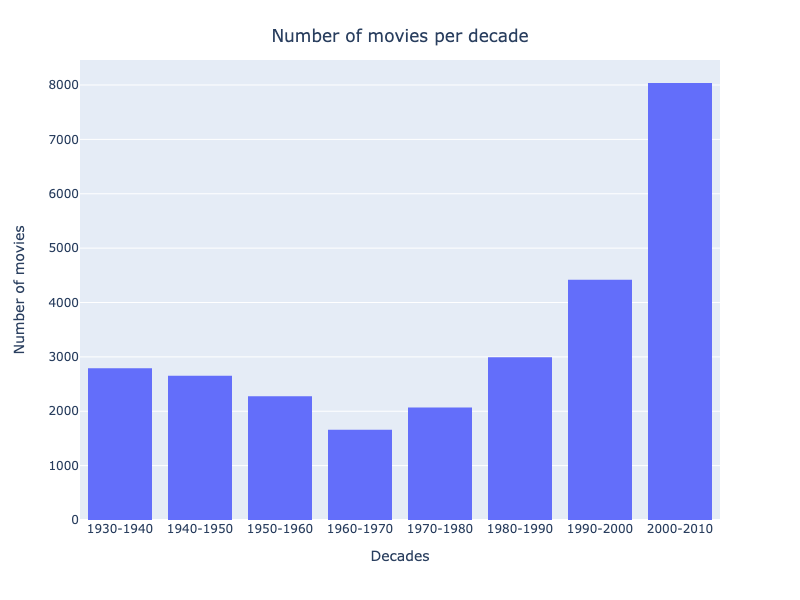

In [13]:
#Import dataframe
df = pd.read_csv('df_movie_usa.csv')

#Years od decades
years = ['1930','1940','1950','1960','1970','1980','1990','2000','2010']


#Initialisation of the decade dictionnary
dic_movie_decades = dict.fromkeys(decades)
for ctr in range(len(years)-1):
    decade_str = years[ctr]+'-'+years[ctr+1]
    dic_movie_decades[decade_str] = {'dataframe' : df[ (df.Movie_date > years[ctr]) & (df.Movie_date < years[ctr+1])] ,
                                   'occurences': len(df[ (df.Movie_date > years[ctr]) & (df.Movie_date < years[ctr+1])] )}

#Plot
data = [dic_movie_decades[decade]['occurences'] for decade in decades]
plot4 = px.histogram(x = decades, y = data, labels={'x':'Decades', 'y':'Number of movies'}, width=800, height=600)
title4 = {'text': "Number of movies per decade", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}
plot4.for_each_yaxis(lambda a: a.update(title_text=a.title.text.replace("sum of", "")))
plot4.update_layout(title=title4)
plot4.write_html("plot/plot4.html")
plot4.write_image("plot/plot4.png")
Image(filename='plot/plot4.png')

## Exploration of characters

### Distribution of man/woman

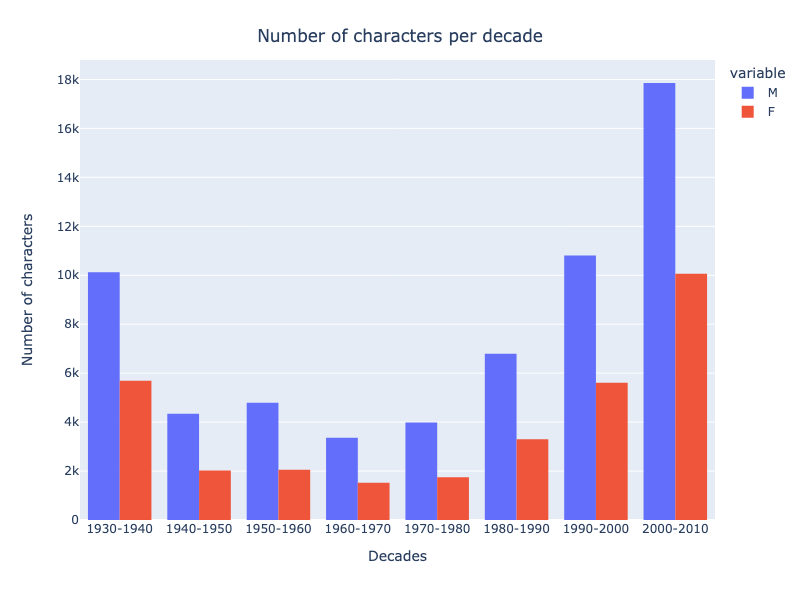

In [14]:
df = df_character_usa_summary_results

#Group by decade end count the number of male/female character
s_m = pd.Series(df[df.Actor_gender=='M'].groupby('Decade')['Actor_gender'].count(),name='M')
s_f = pd.Series(df[df.Actor_gender=='F'].groupby('Decade')['Actor_gender'].count(),name='F')
df2 = pd.concat([s_m,s_f],axis=1)
df2 = df2.reset_index()


#Plot
plot6 = px.histogram(df2, x=decades, y=["M", "F"], barmode='group', labels={'x':'Decades', 'value':'Number of characters'}, width=800, height=600)
title6 = {'text': "Number of characters per decade", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}
plot6.for_each_yaxis(lambda a: a.update(title_text=a.title.text.replace("sum of", "")))
plot6.update_layout(title=title6)
plot6.write_html("plot/plot6.html")
plot6.write_image("plot/plot6.png")
Image(filename='plot/plot6.png')

### Representation of gender 

In [15]:
#Principal genres
df1 = df_movie_usa.copy()
genre_count = df1['Main_genre'].value_counts()
main_genre = genre_count[genre_count>800] #we assume a main genre when there are more than 800 movies

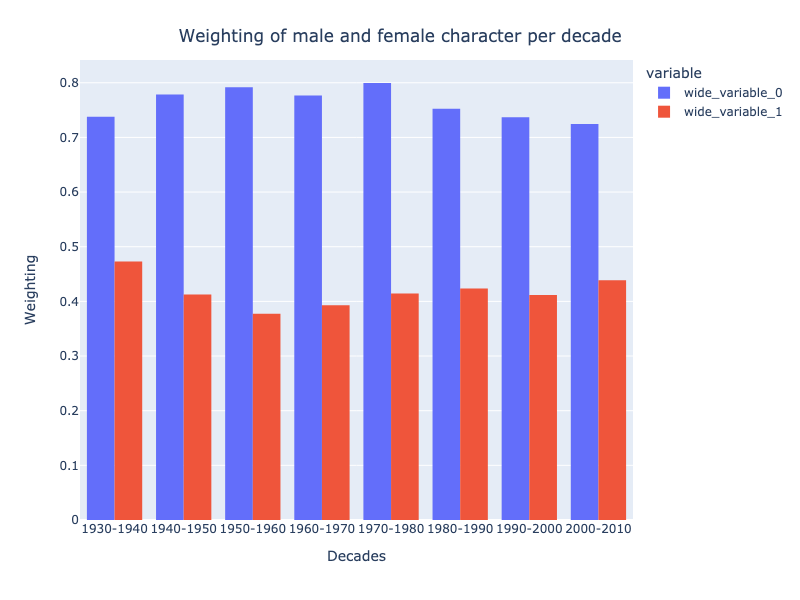

In [16]:
#Group by decade and movie and compute the mean weighting for male and female
df = df_character_usa_summary_results
s_m = pd.Series(df[df.Actor_gender=='M'].groupby(['Decade','Wikipedia_movie_ID'])['Weighting'].sum(),name='M')
s_f = pd.Series(df[df.Actor_gender=='F'].groupby(['Decade','Wikipedia_movie_ID'])['Weighting'].sum(),name='F')
df_m=pd.DataFrame(s_m).reset_index()
df_f=pd.DataFrame(s_f).reset_index()
s1 = df_m.groupby('Decade')['M'].mean()
s2 = df_f.groupby('Decade')['F'].mean()
df2=pd.concat([s1,s2],axis=1).reset_index()

#Plot
plot7 = px.histogram(x=decades, y=[df2.M,df2.F], barmode='group', labels={'x':'Decades', 'value':'Weighting'}, width=800, height=600)
title7 = {'text': "Weighting of male and female character per decade", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}
plot7.for_each_yaxis(lambda a: a.update(title_text=a.title.text.replace("sum of", "")))
plot7.update_layout(title=title7)
plot7.write_html("plot/plot7.html")
plot7.write_image("plot/plot7.png")
Image(filename='plot/plot7.png')

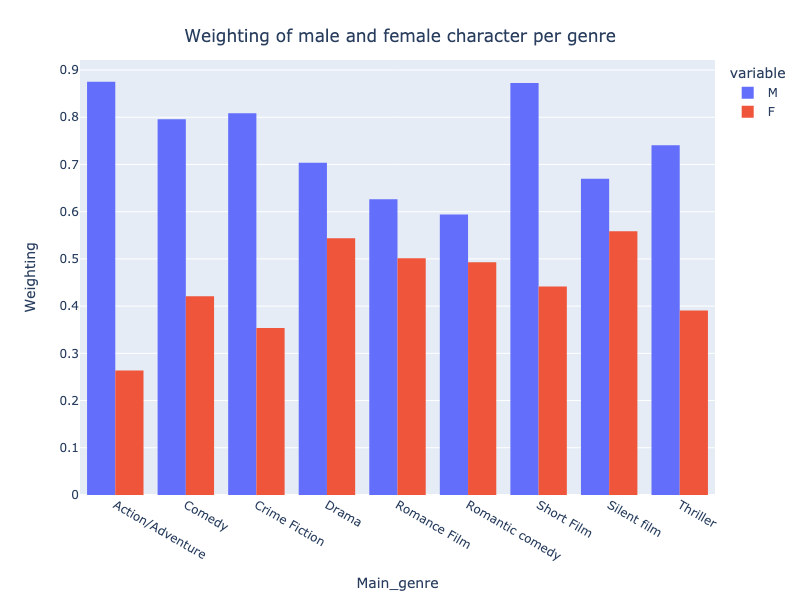

In [17]:
#Group by genre and movie and compute the mean weighting for male and female
df = df_character_usa_summary_results.merge(df_movie_usa[['Wikipedia_movie_ID','Main_genre']],on='Wikipedia_movie_ID')
s_m = pd.Series(df[df.Actor_gender=='M'].groupby(['Main_genre','Wikipedia_movie_ID'])['Weighting'].sum(),name='M')
s_f = pd.Series(df[df.Actor_gender=='F'].groupby(['Main_genre','Wikipedia_movie_ID'])['Weighting'].sum(),name='F')
df_m=pd.DataFrame(s_m).reset_index()
df_f=pd.DataFrame(s_f).reset_index()
s1 = df_m.groupby('Main_genre')['M'].mean()
s2 = df_f.groupby('Main_genre')['F'].mean()
df2=pd.concat([s1,s2],axis=1).reset_index()

df2_main_genre = df2[df2.Main_genre.isin(main_genre.index)]

#Plot
plot8 = px.histogram(df2_main_genre, x='Main_genre', y=["M", "F"], barmode='group', labels={'x':'Main genre', 'value':'Weighting'}, width=800, height=600)
title8 = {'text': "Weighting of male and female character per genre", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}
plot8.for_each_yaxis(lambda a: a.update(title_text=a.title.text.replace("sum of", "")))
plot8.update_layout(title=title8)
plot8.write_html("plot/plot8.html")
plot8.write_image("plot/plot8.png")
Image(filename='plot/plot8.png')

### Gender references in summaries

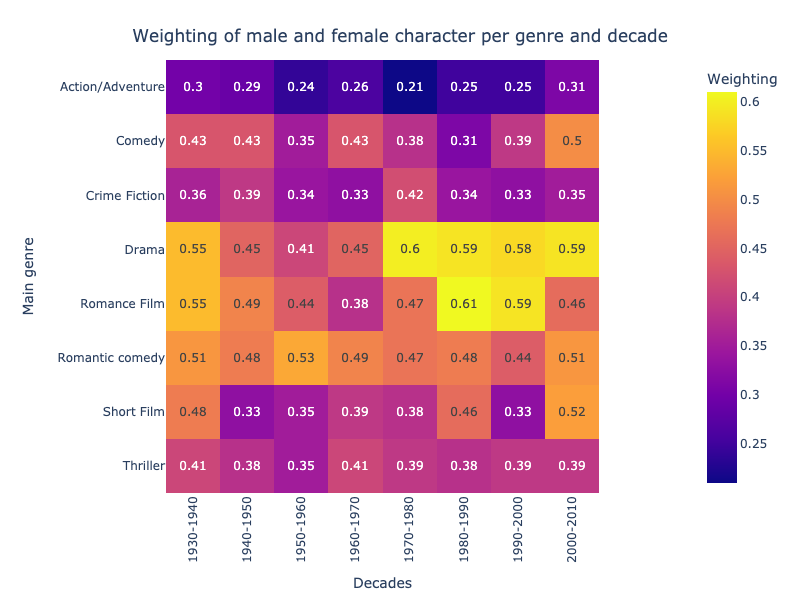

In [18]:
#Group by genre,movie and decades, compute the mean weighting for male and female
df = df_character_usa_summary_results.merge(df_movie_usa[['Wikipedia_movie_ID','Main_genre']],on='Wikipedia_movie_ID')
s_m = pd.Series(df[df.Actor_gender=='M'].groupby(['Main_genre','Decade','Wikipedia_movie_ID'])['Weighting'].sum(),name='M')
s_f = pd.Series(df[df.Actor_gender=='F'].groupby(['Main_genre','Decade','Wikipedia_movie_ID'])['Weighting'].sum(),name='F')
df_m=pd.DataFrame(s_m).reset_index()
df_f=pd.DataFrame(s_f).reset_index()

#Mean weighting
s1 = df_m.groupby(['Main_genre','Decade'])['M'].mean()
s2 = df_f.groupby(['Main_genre','Decade'])['F'].mean()
df2=pd.concat([s1,s2],axis=1).reset_index()

#Construct dataframe for heatmap
df2_main_genre = df2[df2.Main_genre.isin(main_genre.index)]
df2_main_genre.set_index(['Decade', 'Main_genre'], inplace=True)
df3 = df2_main_genre.reset_index().pivot(columns='Decade',index='Main_genre',values='F')
df3.drop('Silent film',axis=0,inplace=True) #remove silent film because very few data after 1940

#Plot
plot9 = px.imshow(df3.round(2),x=decades, labels={'x':'Decades', 'y':'Main genre', 'color':'Weighting'}, width=800, height=600, text_auto = True)
title9 = {'text': "Weighting of male and female character per genre and decade", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}
plot9.update_xaxes(tickangle=-90)
plot9.for_each_yaxis(lambda a: a.update(title_text=a.title.text.replace("sum of", "")))
plot9.update_layout(title=title9)
plot9.write_html("plot/plot9.html")
plot9.write_image("plot/plot9.png")
Image(filename='plot/plot9.png')


## Analysis

### Extract most important adjectives and verbs 

In [19]:
#Group by gender and decade
df = df_character_usa_summary_results.copy()
adj_decades = df.groupby(['Decade','Actor_gender'])['Adjectives'].agg('sum')
verb_decades = df.groupby(['Decade','Actor_gender'])['Verbs'].agg('sum')

In [20]:
#Create a dataframa with all adjectives/verbs for each gender en decade
adj_decades_list, verb_decades_list = [] , []
for decade in verb_decades.index:
   adj_decades_list.append( adj_decades[decade].split("'")[1::2] ) 
   verb_decades_list.append( verb_decades[decade].split("'")[1::2] ) 

df_decades = pd.DataFrame()
df_decades.index = verb_decades.index
df_decades['Adjectives'] = adj_decades_list
df_decades['Verbs'] = verb_decades_list


In [21]:
df_decades

Adjectives  \
Decade Actor_gender                                                      
0      F             [unemployed, loyal, elder, american, sheltered...   
       M             [young, young, formidable, crooked, new, giant...   
1      F             [left, susan alexander kane, second, former, f...   
       M             [dead, mysterious, jewish, unskilled, good, ob...   
2      F             [new, small, female, old, unsuspecting, young,...   
       M             [transvestite, ambitious, private, last, other...   
3      F             [promiscuous, kinda, late, female, even, impov...   
       M             [entire, other, irish, first, inexperienced, a...   
4      F             [german, beautiful, upset, castle, explosive, ...   
       M             [new, new, mysterious, martial, only, young, a...   
5      F             [assistant, experimental, sad, upset, same, ta...   
       M             [criminal, mouthed, violent, new, mysterious, ...   
6      F             [carefree, popular, main, good, thaw, recent, ...   
       M             [vampiric, makeshift, ill, deformed, vengeful,...   
7      F             [liberated, alien, qualified, tomboyish, old, ...   
       M             [skeptical, other, blind, blind, blind, luis v...   

                                                                 Verbs  
Decade Actor_gender                                                     
0      F             [take, break, learn, go, break, fall, free, wa...  
       M             [idolize, gain, meet, persuade, go, flee, fain...  
1      F             [live, die, approach, send, enter, begin, marr...  
       M             [take, attempt, try, approach, go, learn, find...  
2      F             [offer, bring, sing, go, come, dismiss, become...  
       M             [experiment, use, irradiate, read, act, decide...  
3      F             [disguise, lure, see, begin, return, confront,...  
       M             [get, head, win, construct, say, climb, pose, ...  
4      F             [devote, seduce, drop, plan, commit, release, ...  
       M             [work, have, gather, realize, order, boobytrap...  
5      F             [visit, leave, disappear, kill, try, live, mee...  
       M             [refuse, tell, find, hang, end, find, leave, t...  
6      F             [refuse, start, find, confront, become, meet, ...  
       M             [land, fight, grow, return, start, enter, duck...  
7      F             [fight, study, refuse, visit, destroy, injure,...  
       M             [arrive, kill, regain, decide, prepare, confes...

### Remove stopwords

In [22]:
nlp = spacy.load('en_core_web_sm') 
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS )

for i in range(len(df_decades)):
    df_decades.iloc[i]['Adjectives'] = [word for word in df_decades.iloc[i]['Adjectives'] if word not in spacy_stopwords]
    df_decades.iloc[i]['Verbs'] = [word for word in df_decades.iloc[i]['Verbs'] if word not in spacy_stopwords]

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_52915/4123396232.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_52915/4123396232.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Adjectives

### Most common adjectives and verbs (Wordcloud)

In [23]:
#Create function which plot wordcloud for each decade and gender
def wordcloud_decades(df,decades,pos):
    fig, ax = plt.subplots(8,2,figsize= (15,15))
    for ctr,decade in enumerate(decades):
        text = df.loc[ctr,'M'][pos]
        sbplt = ax[ctr,0]
        unique_string= ' '.join(map(str, text))
        wordcloud = WordCloud(width = 1600, height = 500).generate(unique_string)
        sbplt.imshow(wordcloud)
        sbplt.axis("off")   
        sbplt.set_title(decade)
    for ctr,decade in enumerate(decades):
        text = df.loc[ctr,'F'][pos]
        sbplt = ax[ctr,1]
        unique_string=(" ").join(text)
        wordcloud = WordCloud(width = 1600, height = 500).generate(unique_string)
        sbplt.imshow(wordcloud)
        sbplt.axis("off")   
        sbplt.set_title(decade)
    plt.show()

In [24]:
#Create function which plot wordcloud for each gender (over all decades)
def wordcloud(mask_image_m,mask_image_f,df,pos):
    df = df.reset_index()

    #Initialise the figure
    fig, ax = plt.subplots(1,2,figsize= (15,15))
    
    #Show wordcloud for male and female
    for ctr,gender in enumerate(['M','F']):
        text = df[df.Actor_gender==gender][pos]
        text = sum(text, []) #flatten the list of words
        unique_string= (" ").join(text)
        if gender=='M':
            mask_ = np.array(Image.open(mask_image_m)) 
        else:
            mask_ = np.array(Image.open(mask_image_f))
        
        wordcloud = WordCloud(width = 1600, height = 500, mask=mask_ , contour_width=6, contour_color='black', background_color="white" , max_words=100).generate(unique_string) #generate wordcloud
        
        sbplt = ax[ctr]
        sbplt.imshow(wordcloud)
        sbplt.axis("off")   

    plt.show()




#### Adjectives

AttributeError: type object 'Image' has no attribute 'open'

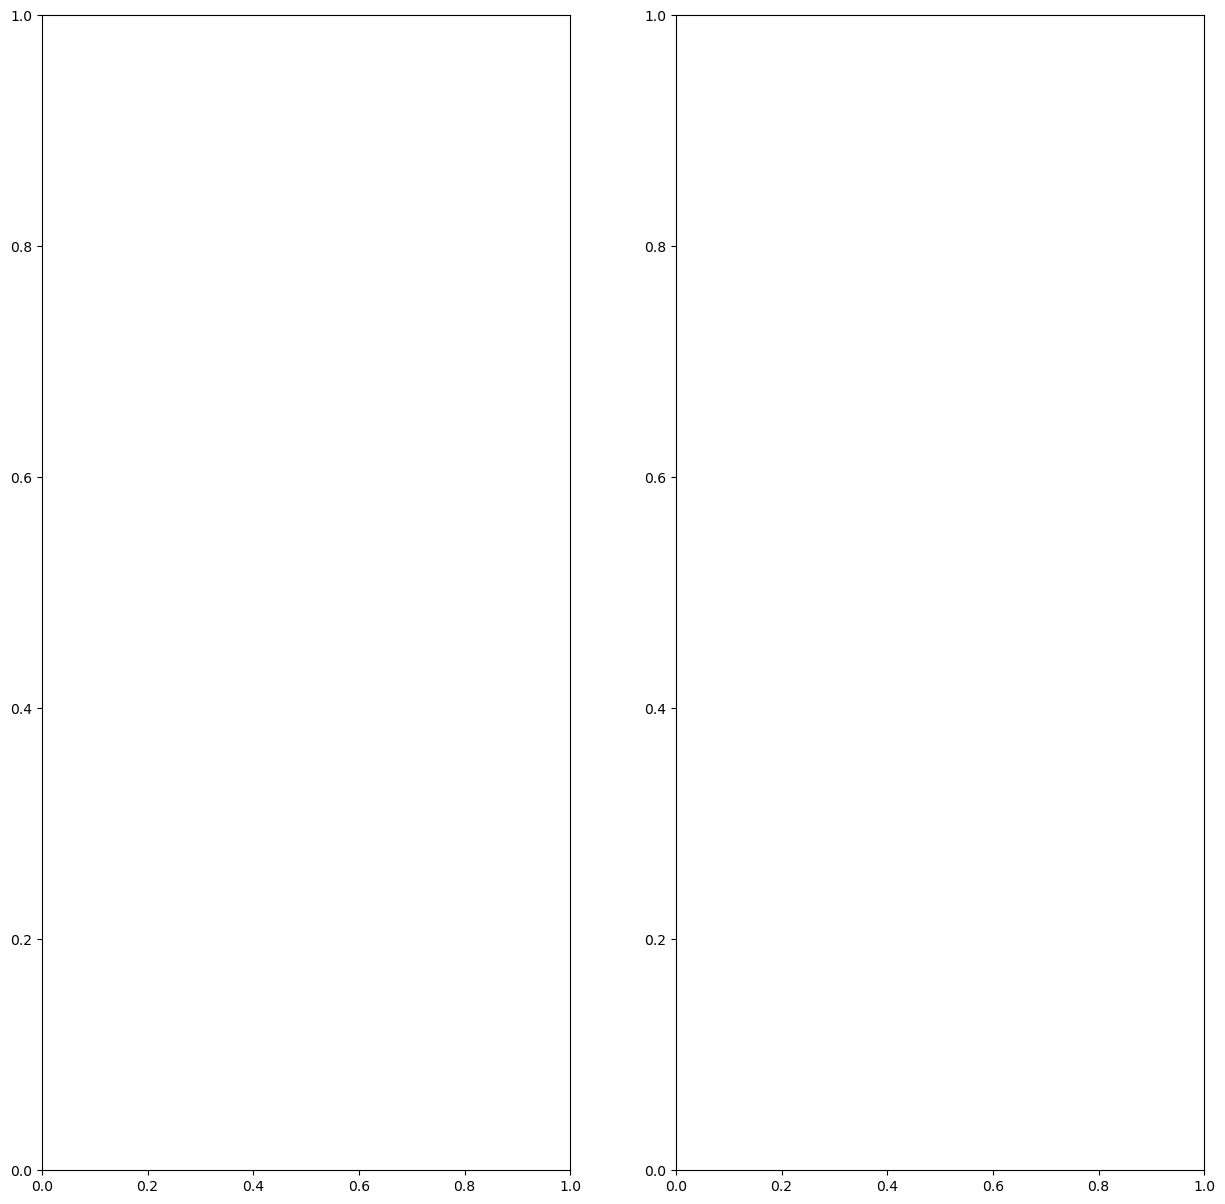

In [25]:
#Plot wordcloud for adjectives
wordcloud('male.png','female.png',df_decades,'Adjectives')

#### Verbs

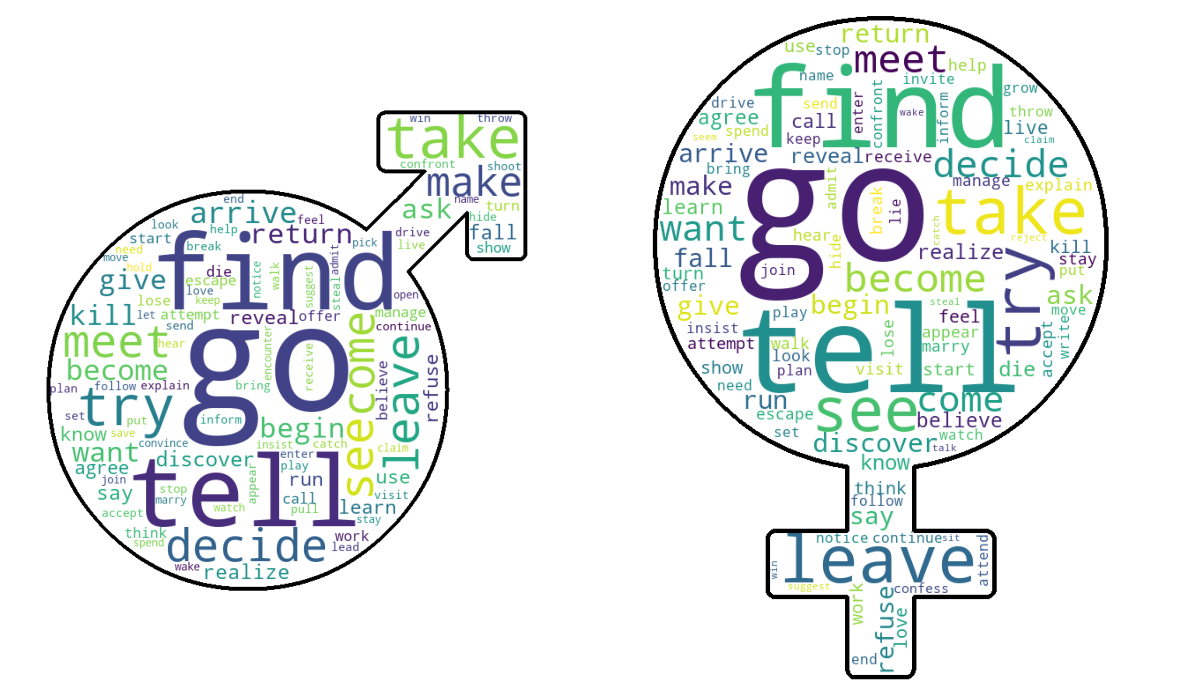

In [ ]:
#Plot wordcloud for verbs
wordcloud('male.png','female.png',df_decades,'Verbs')

It is difficult to differentiate men and women only based on words. This might be due to the significant number of different words. In order to reduce the scope of the data, we chose to analyse lexical the fields. From this, we normalize the data to 194 features (lexical fields) which allow to compare more accurately men, women, and decades.

### Lexical analysis

#### Empath

Empath is a tool for analyzing text across lexical categories (similar to LIWC), and also generating new lexical categories to use for an analysis. It assigns a score to each lexical field, normalized over all the words of the input list. The categories are presented below:

In [26]:
print(lexical_fields)

['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic', 'celebr

In [27]:
#Function analyzing the lexical field in a list of words
def lex_analysis(df,decades,pos):
    '''Calculate score of each lexical category in list of words for each decade, gender
    Parameters:
    df: pd.Series
    decades: list of decades
    pos: str, part of speech, 'Adjectives' or 'Verbs'
    '''   
    #Initialize dataframes
    df_lex  = pd.DataFrame(index =  df.index , columns=lexical_fields) 

    for ctr,decade in enumerate(decades):
        #Lexical analysis 
        df_lex.loc[ctr,'M']= list(lexicon.analyze(df_decades.loc[ctr,'M'][pos], normalize=True).values())
        df_lex.loc[ctr,'F'] = list(lexicon.analyze(df_decades.loc[ctr,'F'][pos], normalize=True).values())
    df_lex = df_lex.reset_index()
    return df_lex


In [28]:
#Lexical analysis of adjectives
df_lex_adj = lex_analysis(df_decades,decades,'Adjectives')
df_lex_adj

,Decade,Actor_gender,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0,F,0.002193,0.0,0.0,0.002193,0.002741,0.000548,0.002193,0.004934,...,0.0,0.071272,0.003289,0.001645,0.0,0.0,0.0,0.000548,0.003289,0.0
1,0,M,0.003983,0.000664,0.000332,0.000664,0.009957,0.000332,0.003319,0.007302,...,0.000996,0.08231,0.010289,0.002987,0.000332,0.0,0.000332,0.000996,0.013276,0.001328
2,1,F,0.014306,0.001431,0.0,0.0,0.017167,0.0,0.001431,0.012876,...,0.001431,0.131617,0.0,0.0,0.0,0.0,0.0,0.001431,0.008584,0.002861
3,1,M,0.001484,0.0,0.000742,0.0,0.002226,0.0,0.000742,0.001484,...,0.0,0.024481,0.002967,0.0,0.0,0.0,0.0,0.000742,0.004451,0.000742
4,2,F,0.007937,0.001587,0.003175,0.0,0.012698,0.0,0.001587,0.019048,...,0.001587,0.146032,0.006349,0.001587,0.001587,0.0,0.0,0.003175,0.009524,0.004762
5,2,M,0.001972,0.001315,0.0,0.001315,0.009204,0.0,0.00263,0.004602,...,0.001315,0.065089,0.008547,0.003945,0.0,0.000657,0.0,0.001972,0.006575,0.000657
6,3,F,0.003738,0.003738,0.001869,0.0,0.011215,0.0,0.001869,0.009346,...,0.001869,0.108411,0.003738,0.0,0.001869,0.001869,0.0,0.0,0.007477,0.0
7,3,M,0.00493,0.000822,0.002465,0.000822,0.001643,0.000822,0.002465,0.003287,...,0.00493,0.082991,0.013147,0.007395,0.0,0.001643,0.0,0.001643,0.013969,0.003287
8,4,F,0.003221,0.00161,0.0,0.0,0.011272,0.0,0.0,0.024155,...,0.00161,0.125604,0.012882,0.0,0.0,0.0,0.0,0.003221,0.008052,0.00161
9,4,M,0.002708,0.000677,0.000677,0.000677,0.005416,0.0,0.004062,0.004739,...,0.002031,0.067705,0.009479,0.002031,0.0,0.000677,0.000677,0.002708,0.010156,0.002708


In [29]:
#Lexical analysis of verbs
df_lex_verb = lex_analysis(df_decades,decades,'Verbs')
df_lex_verb

,Decade,Actor_gender,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0,F,0.016198,0.00128,0.003451,0.005344,0.027888,0.002171,0.004787,0.008572,...,0.00924,0.001948,0.000223,0.000891,0.053716,0.004342,0.005232,0.005789,0.01887,0.00796
1,0,M,0.01645,0.00095,0.001871,0.006759,0.02117,0.001508,0.003296,0.007653,...,0.014439,0.001648,0.000307,0.00081,0.045692,0.002206,0.004329,0.002569,0.011144,0.005446
2,1,F,0.019214,0.000529,0.004407,0.008814,0.034373,0.001058,0.003525,0.009342,...,0.010929,0.002115,0.000176,0.000353,0.057994,0.004936,0.003878,0.006698,0.020448,0.010576
3,1,M,0.019801,0.001042,0.003061,0.008402,0.023513,0.001433,0.003908,0.008207,...,0.012636,0.001628,0.000391,0.001368,0.050088,0.002996,0.005341,0.002149,0.011659,0.007165
4,2,F,0.018363,0.001248,0.003922,0.007845,0.031556,0.001248,0.002853,0.00731,...,0.005883,0.002496,0.000357,0.000891,0.053842,0.00624,0.004101,0.006062,0.01979,0.00624
5,2,M,0.019741,0.001009,0.002972,0.007627,0.024844,0.002355,0.00387,0.007627,...,0.017554,0.001346,0.000393,0.001402,0.051147,0.003028,0.003589,0.002748,0.012843,0.005384
6,3,F,0.015843,0.00048,0.003601,0.006241,0.029765,0.00096,0.003841,0.009361,...,0.008161,0.0024,0.00072,0.00096,0.050888,0.006721,0.003841,0.006961,0.019923,0.006721
7,3,M,0.008442,0.000528,0.000703,0.003078,0.009233,0.000967,0.000703,0.00299,...,0.010288,0.001055,0.000176,0.00044,0.01961,0.001055,0.001935,0.001847,0.004397,0.000879
8,4,F,0.019673,0.000828,0.003106,0.005384,0.022158,0.000414,0.005591,0.008905,...,0.012839,0.001242,0.000414,0.001035,0.050528,0.005591,0.002278,0.006834,0.013667,0.007455
9,4,M,0.015969,0.001425,0.002249,0.008697,0.024067,0.002099,0.004798,0.009372,...,0.023842,0.00105,0.000825,0.0009,0.053381,0.004049,0.002924,0.005098,0.010121,0.006148


#### Barlot lexical (all decades)

In [30]:
def barplot_lex(df,pos):
    '''Plot barplot of lexical categories for adjcetives or verbs, over all decades
    Parameters:
    df: pd.Series
    pos: str, part of speech, 'Adjectives' or 'Verbs'
    '''   

    #Compute mean across all decades
    df_m = pd.Series(df[df.Actor_gender=='M'].iloc[:,2:].mean(),name='m')
    df_f = pd.Series(df[df.Actor_gender=='F'].iloc[:,2:].mean(),name='f')
    df = pd.concat([df_m,df_f],axis=1)
    df_barplot = df.reset_index()

    #Plot barplot

    #Initialisation of figure
    fig, ax = plt.subplots(1,2, figsize=(15, 33))
    #Initialisation of colors
    palette = sns.color_palette("coolwarm", n_colors = len(df_barplot))
    palette.reverse()
    
    #Male
    df_barplot_m = df_barplot.sort_values(by='m',ascending=False)
    sns.barplot( x='m', y = 'index', data=df_barplot_m, ax = ax[0], palette = palette)
    ax[0].set_title('Male associated '+pos+' lexical fields', fontsize = 17)
    ax[0].set_xlabel("Mean score", fontsize = 14)
    ax[0].set_ylabel("Lexical fields", fontsize = 14)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    
    #Female
    df_barplot_f = df_barplot.sort_values(by='f',ascending=False)
    sns.barplot(x = 'f', y = 'index', data=df_barplot_f, ax = ax[1], palette = palette)
    ax[1].set_title('Female associated '+pos+' lexical fields', fontsize = 17)
    ax[1].set_xlabel("Mean score", fontsize = 14)
    ax[1].set_ylabel("Lexical fields", fontsize = 14)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    fig.tight_layout(h_pad=2)
    

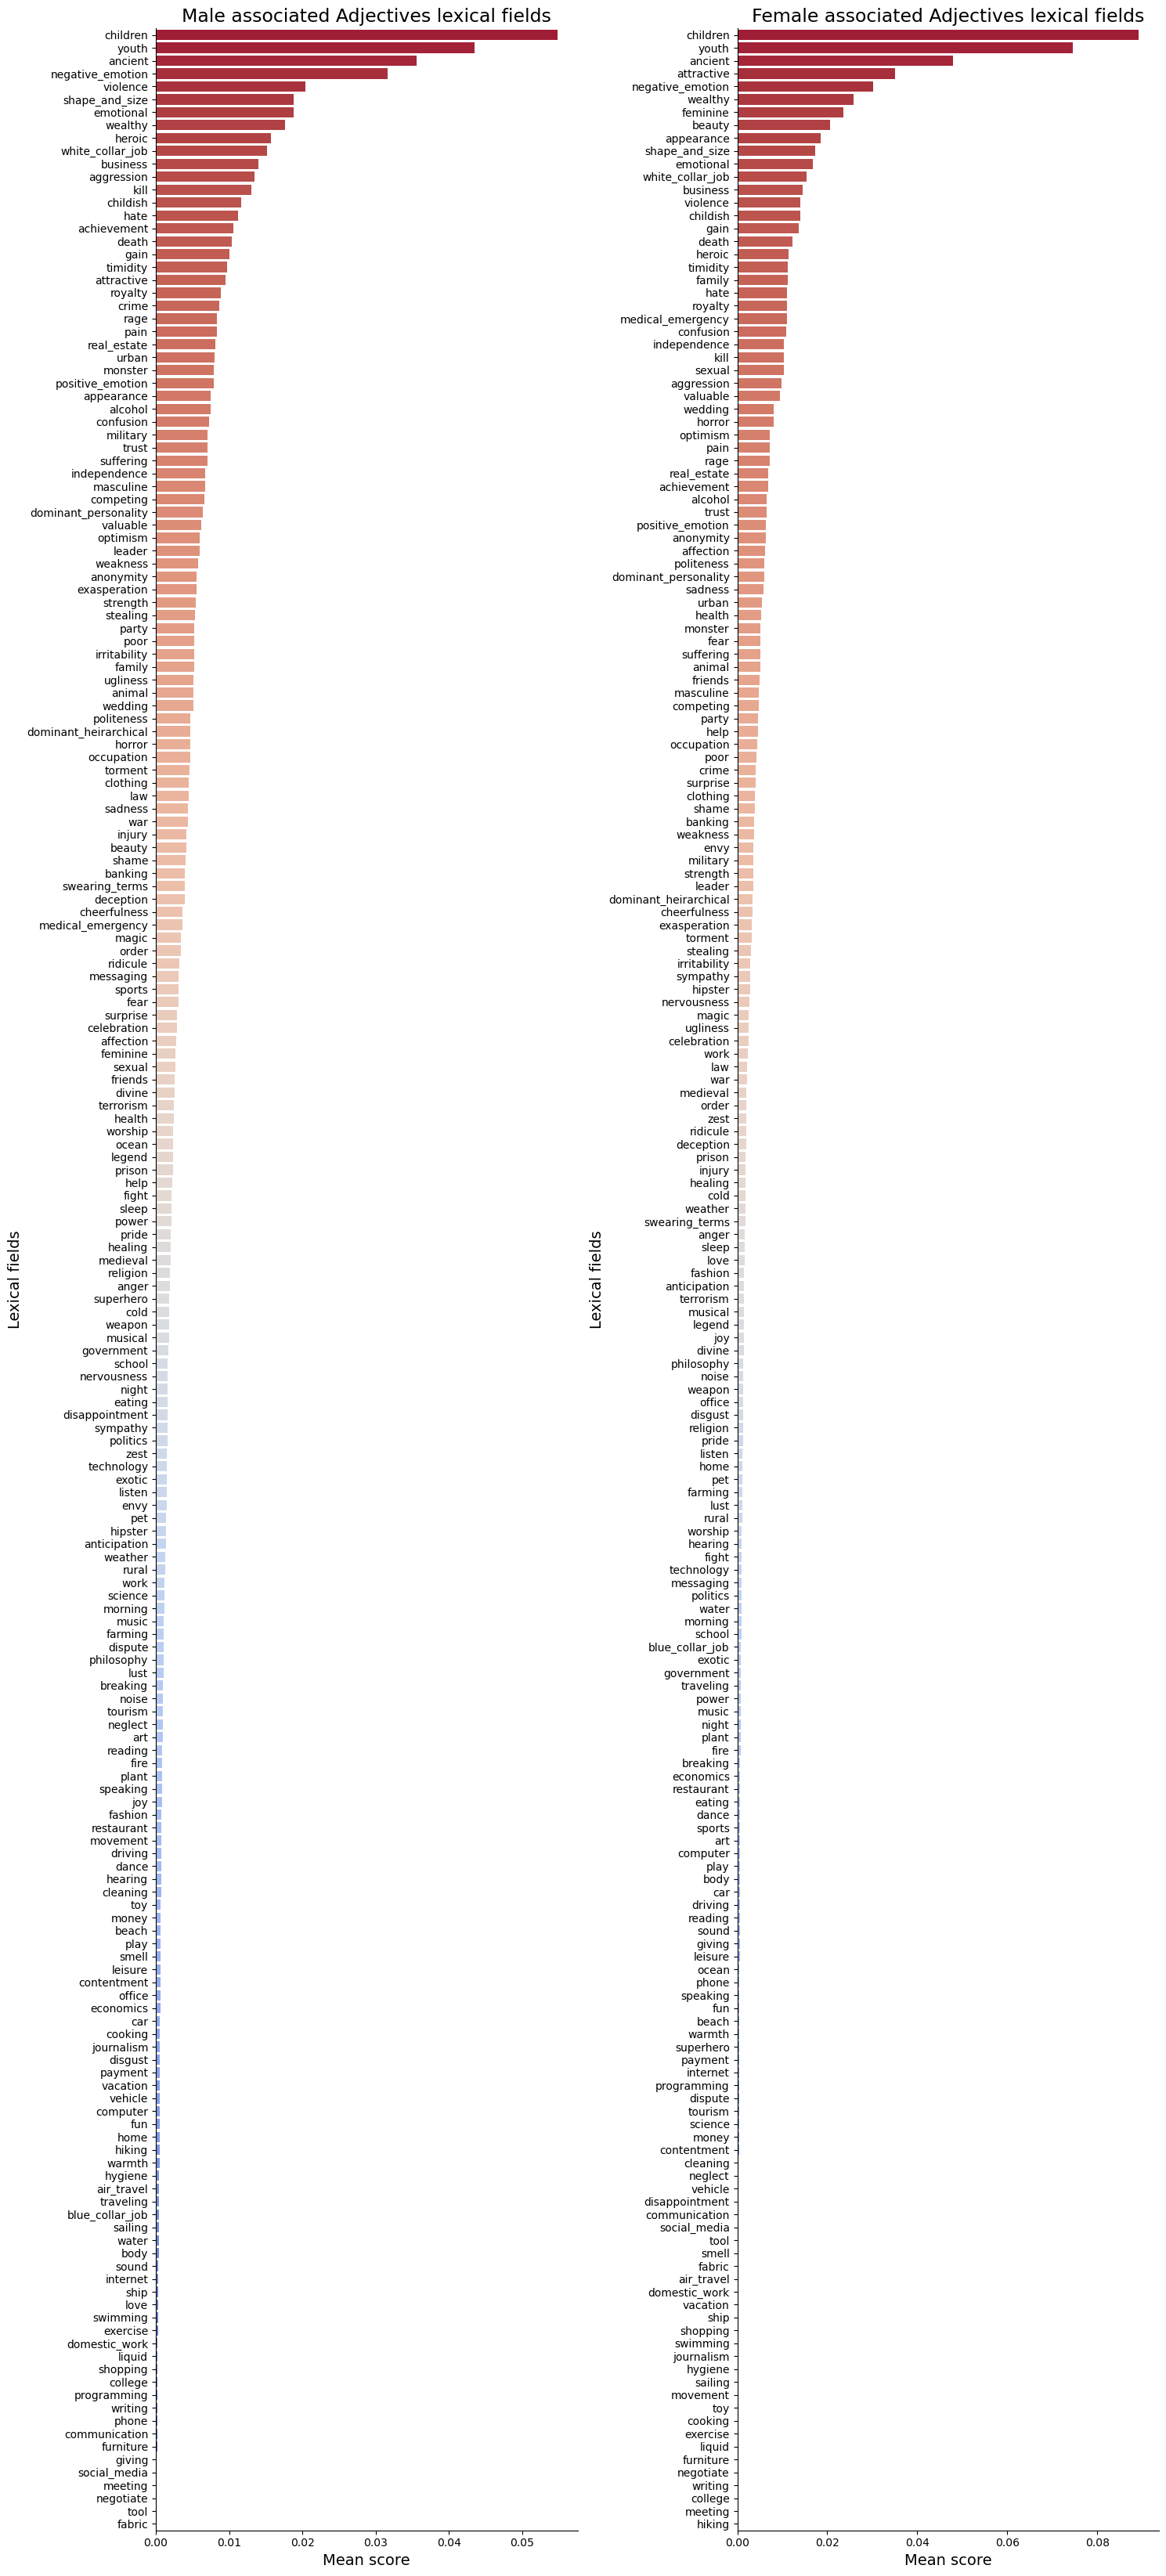

In [31]:
#Barplot for adjectives
barplot_lex(df_lex_adj,'Adjectives')

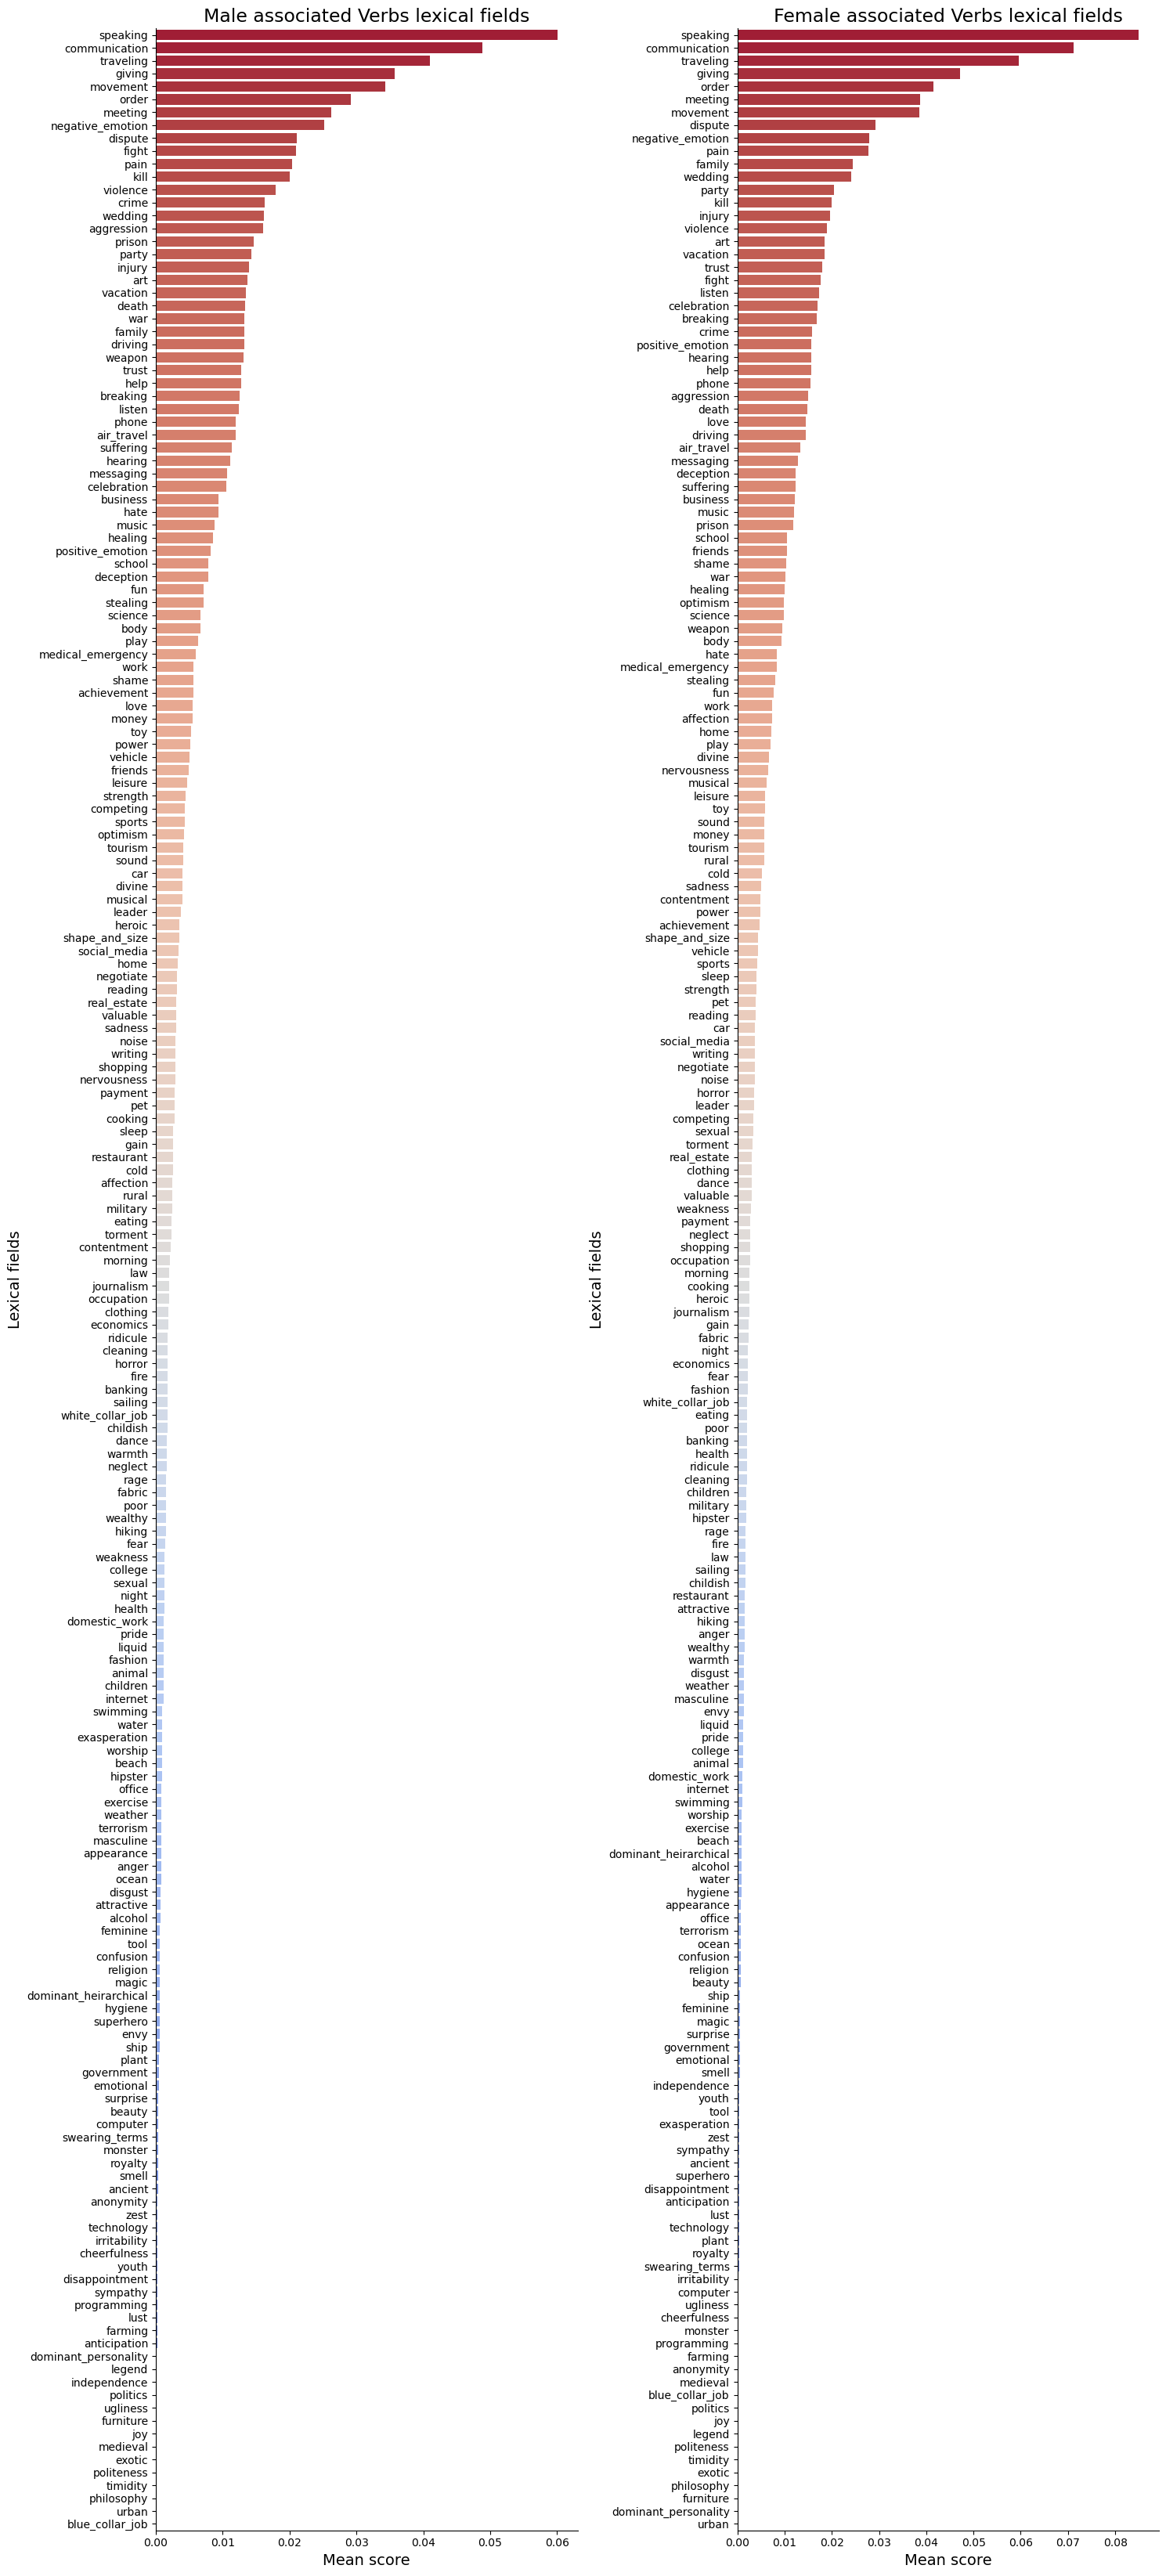

In [32]:
#Barplot for verbs
barplot_lex(df_lex_verb,'Verbs')

 #### Evolution of lexical categories scores

In [33]:
def important_features(df1,decades,max_rank):
    '''Identify the most important features for each decades and gender, using the score of the features. 
    Differentiate men and women by taking the opposite of their intersection
    Parameters:
    df1: pd.Series
    decades: list of decades
    max_rank: int, number of most important features to be considered 
    '''
    dic_features = dict.fromkeys(decades_code,[])
    for ctr,decade in enumerate(decades):
        features = []
        for gender in ['M','F']:
            df = df1.copy()
            df = df[ (df.Decade==ctr) & (df.Actor_gender==gender) ].iloc[:,2:].T
            df.columns = ['score']
            df = df.sort_values(by='score',ascending=False)
            features.append(df.index[0:max_rank]) #taking the top max_rank features

        features_m_unique = list(set(features[0]).difference(features[1])) #remove common elements of male and female
        features_f_unique = list(set(features[1]).difference(features[0])) #remove common elements of male and female

        dic_features[ctr] = {'M':features_m_unique , 'F':features_f_unique}
        
    df_important_features = pd.DataFrame(dic_features)
    return df_important_features

In [34]:
#Adjectives
df_features_adj = important_features(df_lex_adj,decades,10)
#Verbs
df_features_verb = important_features(df_lex_verb,decades,10)

In [35]:
df_features_adj

,0,1,2,3,4,5,6,7
M,"[emotional, violence, white_collar_job, heroic]","[kill, achievement, white_collar_job, violence...","[emotional, violence, heroic, childish]","[kill, emotional, heroic, shape_and_size]","[wealthy, urban, violence, business, real_estate]","[aggression, violence, white_collar_job, shape...","[violence, emotional, heroic, shape_and_size, ...","[violence, emotional, white_collar_job]"
F,"[royalty, feminine, attractive, childish]","[emotional, shape_and_size, beauty, feminine, ...","[gain, appearance, white_collar_job, attractive]","[appearance, white_collar_job, feminine, attra...","[appearance, medical_emergency, beauty, femini...","[confusion, beauty, feminine, attractive]","[wealthy, royalty, business, health, attractive]","[achievement, independence, attractive]"


In [36]:
df_features_verb

,0,1,2,3,4,5,6,7
M,[fight],[pain],"[pain, negative_emotion]","[kill, negative_emotion, fight]","[kill, fight]","[kill, fight]","[kill, fight]","[kill, fight]"
F,[pain],[wedding],"[family, wedding]","[pain, wedding, dispute]","[pain, dispute]","[pain, dispute]","[pain, dispute]","[pain, dispute]"


In [37]:


def feature_evolution(df1,df2,gender):
    '''Plot the evolution of the features over the decades
    df1: pd.DataFrame, 
    df2: pd.DataFrame,
    gender: str, 'M' or 'F'
    '''
    # Create a list of all features and remove common elements between men and women
    all_features_m = df1.loc['M'].sum()
    all_features_f = df1.loc['F'].sum()
    
    # Remove features that appear only in one decade
    count_m = Counter(all_features_m)
    all_features_m = [feature for feature in list(count_m.keys()) if count_m[feature]>1]
    count_f = Counter(all_features_f)
    all_features_f = [feature for feature in list(count_f.keys()) if count_f[feature]>1]   

    #Remove common features between male and female
    all_features_m = list(set(all_features_m).difference(all_features_f)) 
    all_features_f = list(set(all_features_f).difference(all_features_m)) 



    #Select the corresponding gender
    if gender == 'M':
        all_features = all_features_m
    if gender == 'F':
        all_features = all_features_f
    
    #Create the feature evolution dataframe
    df_feature_evolution = pd.DataFrame()
    for feature in all_features:
        df_feature_evolution[feature] = df2[df2.Actor_gender==gender][feature].values
    return df_feature_evolution,all_features
        

In [38]:
#Adjectives
df_feature_evolution_m_adj, all_features_m_adj= feature_evolution( df_features_adj,df_lex_adj,'M')
df_feature_evolution_f_adj, all_features_f_adj  = feature_evolution( df_features_adj,df_lex_adj,'F')

In [39]:

#Verbs
df_feature_evolution_m_verb, all_features_m_verb = feature_evolution( df_features_verb,df_lex_verb,'M')
df_feature_evolution_f_verb, all_features_f_verb = feature_evolution( df_features_verb,df_lex_verb,'F')

 ##### Male lexical fields from adjectives

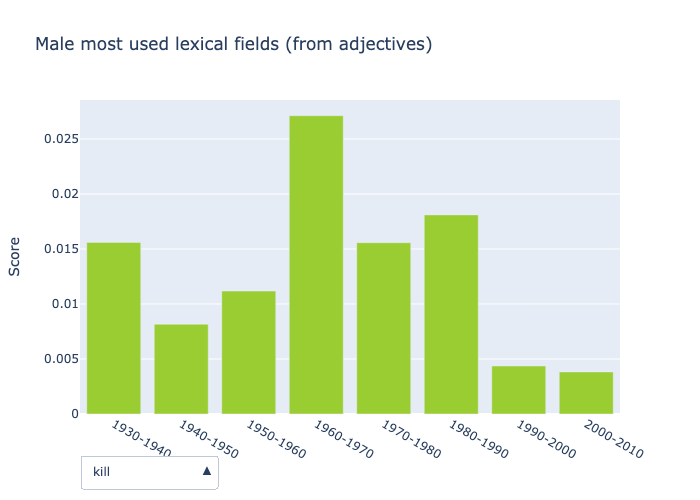

In [40]:
#male adjectives

# Initialize figure
plot10 = go.Figure()

# Add Traces
color= 'yellowgreen'
plot10.add_trace(
    go.Bar(y=df_feature_evolution_m_adj.kill,x=decades, marker={'color': color},
               name="Male Adjective ['kill']",
               visible=True)
               )
plot10.add_trace(
    go.Bar(y=df_feature_evolution_m_adj.shape_and_size,x=decades, marker={'color': color},
               name="Male Adjective ['shape_and_size']",
               visible=False)
               )
plot10.add_trace(
    go.Bar(y=df_feature_evolution_m_adj.emotional,x=decades, marker={'color': color},
               name="Male Adjective ['emotional']",
               visible=False)
               )
plot10.add_trace(
    go.Bar(y=df_feature_evolution_m_adj.childish,x=decades, marker={'color': color},
               name="Male Adjective ['childish']",
               visible=False)
               )

plot10.add_trace(
    go.Bar(y=df_feature_evolution_m_adj.heroic,x=decades, marker={'color': color},
               name="Male Adjective ['heroic']",
               visible=False)
               )


button_layer_1_height = -0.1
button_layer_2_height = -0.1

plot10.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="kill",
                     method="update",
                     args=[{"visible": [True, False, False, False, False, False]},
                          ]),
                dict(label="shape_and_size",
                     method="update",
                     args=[{"visible": [False, True, False, False, False, False]},
                          ]),
                dict(label="emotional",
                     method="update",
                     args=[{"visible": [False, False, True, False, False, False]},
                           ]),
                dict(label="childish",
                     method="update",
                     args=[{"visible": [False, False, False, True, False, False]},
                           ]),
                dict(label="heroic",
                     method="update",
                     args=[{"visible": [False, False, False, False, True, False]},
                          ]),
            ]),
                        type = "dropdown",
            direction="up",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
            
        )
    ])



# Set title
plot10.update_layout(title_text="Male most used lexical fields (from adjectives) ",
                    yaxis_title="Score")
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000)
plot10.write_html('plot/plot10.html')
plot10.write_image("plot/plot10.png")
Image(filename='plot/plot10.png')

##### Male lexical fields from verbs

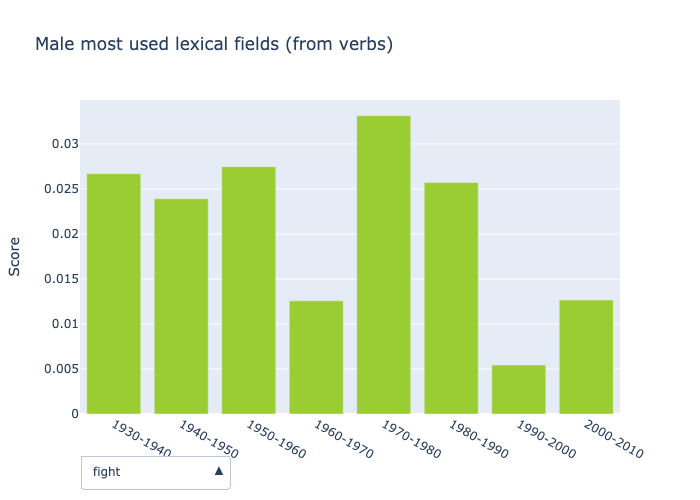

In [41]:
#male verbs

# Initialize figure
plot11 = go.Figure()
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']

# Add Traces
color= 'yellowgreen'
plot11.add_trace(
    go.Bar(y=df_feature_evolution_m_verb.fight,x=decades, marker={'color': color},
            name="Male Verb ['fight']",
               visible=True)
               )
plot11.add_trace(
    go.Bar(y=df_feature_evolution_m_verb.kill,x=decades, marker={'color': color},
               name="Male Verb ['kill']",
               visible=False)
               )
plot11.add_trace(
    go.Bar(y=df_feature_evolution_m_verb.negative_emotion,x=decades, marker={'color': color},
               name="Male Verb ['Negative Emotion']",
               visible=False)
               )

button_layer_1_height = -0.1
button_layer_2_height = -0.1

plot11.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="fight",
                     method="update",
                     args=[{"visible": [True, False, False]},
                          ]),
                dict(label="kill",
                     method="update",
                     args=[{"visible": [False, True, False]},
                          ]),
                dict(label="negative_emotion",
                     method="update",
                     args=[{"visible": [False, False, True]},
                           ]),
            ]),
                        type = "dropdown",
            direction="up",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
            
        )
    ])



# Set title
plot11.update_layout(title_text="Male most used lexical fields (from verbs) ", yaxis_title="Score")
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000)
plot11.write_html('plot/plot11.html')
plot11.write_image("plot/plot11.png")
Image(filename='plot/plot11.png')


##### Female lexical fields from adjectives

In [42]:
all_features_f_adj

['appearance',
 'beauty',
 'royalty',
 'feminine',
 'attractive',
 'white_collar_job']

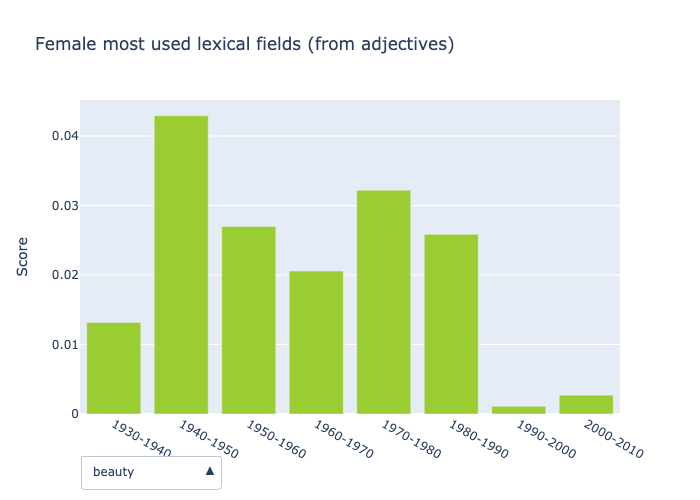

In [43]:
#female adjectives

# Initialize figure
plot12 = go.Figure()
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']

# Add Traces
color = 'yellowgreen'
plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.beauty,x=decades, marker={'color': color},
               name="Female Adjective ['beauty']",
               visible=True)
               )
plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.white_collar_job,x=decades, marker={'color': color},
               name="Female Adjective ['white_collar_job']",
               visible=False)
               )

plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.attractive,x=decades, marker={'color': color},
               name="Female Adjective ['attractive']",
               visible=False)
               )

plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.royalty,x=decades, marker={'color': color},
               name="Female Adjective ['royalty']",
               visible=False)
               )

plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.appearance,x=decades, marker={'color': color},
               name="Female Adjective ['appearance']",
               visible=False)
               )

plot12.add_trace(
    go.Bar(y=df_feature_evolution_f_adj.feminine,x=decades, marker={'color': color},
               name="Female Adjective ['feminine']",
               visible=False)
               )


button_layer_1_height = -0.1
button_layer_2_height = -0.1

plot12.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="beauty",
                     method="update",
                     args=[{"visible": [True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          ]),
                dict(label="white_collar_job",
                     method="update",
                     args=[{"visible": [False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          ]),
                dict(label="attractive",
                     method="update",
                     args=[{"visible": [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                           ]),
                dict(label="royalty",
                     method="update",
                     args=[{"visible": [False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                           ]),
                dict(label="appearance",
                     method="update",
                     args=[{"visible": [False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False]},
                          ]),
                dict(label="feminine",
                     method="update",
                     args=[{"visible": [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          ]),
                
            ]),
                        type = "dropdown",
            direction="up",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
            
        )
    ])



# Set title
plot12.update_layout(title_text="Female most used lexical fields (from adjectives) " , yaxis_title="Score")
plot12.write_html('plot/plot12.html')
plot12.write_image("plot/plot12.png")
Image(filename='plot/plot12.png')

##### Female lexical fields from verb

In [44]:
all_features_f_verb

['pain', 'wedding', 'dispute']

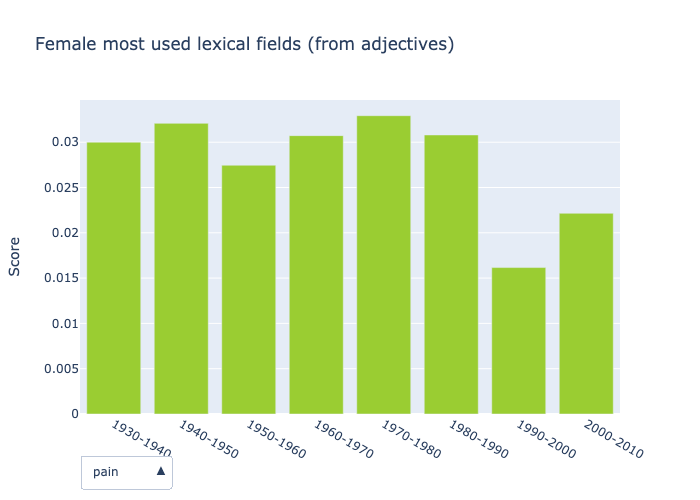

In [45]:
#female verbs

# Initialize figure
plot13 = go.Figure()
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']

# Add Traces
color = 'yellowgreen'
plot13.add_trace(
    go.Bar(y=df_feature_evolution_f_verb.pain,x=decades, marker={'color': color},
            name="Female Verb ['pain']",
               visible=True)
               )
plot13.add_trace(
    go.Bar(y=df_feature_evolution_f_verb.wedding,x=decades, marker={'color': color},
            name="Female Verb ['wedding']",
               visible=False)
               )
plot13.add_trace(
    go.Bar(y=df_feature_evolution_f_verb.dispute,x=decades, marker={'color': color},
            name="Female Verb ['dispute']",
               visible=False)
               )

button_layer_1_height = -0.1
button_layer_2_height = -0.1

plot13.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="pain",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                          ]),
                dict(label="wedding",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           ]),
                dict(label="dispute",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           ]),
            ]),
                        type = "dropdown",
            direction="up",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
            
        )
    ])



# Set title
plot13.update_layout(title_text="Female most used lexical fields (from adjectives) ", yaxis_title="Score")
plot13.write_html('plot/plot13.html')
plot13.write_image("plot/plot13.png")
Image(filename='plot/plot13.png')

#### Exploring the gender bias: Random forest model

Which lexical fields really differentiate men and women?
In this study, we employed a random forest algorithm to classify word samples as associated to male or female. To do this, we generated 100 samples for each gender, consisting of 50 randomly selected adjectives or verbs from decade-specific lists of words. These samples were then analyzed using a lexical method called empath, resulting in 100 vectors for each gender with 194 features (lexical fields). The labels for the vectors were binary, with male represented as 1 and female represented as 0. The random forest algorithm was applied to the resulting 200 vectors (100 vectors for male, 100 vectors for female), and the importance of each feature was extracted.

In [46]:
def random_forest_decades(df , sample_size , n_samples, pos ):
    '''Perform a random forest analysis for each decade
    Parameters:
    df: pd.Series
    sample_size: int, number of element for one sample
    n_samples: int, number of samples
    pos: str, part of speech (adjective or verb)
    '''

    df = df.reset_index()
    df_features_imp = pd.DataFrame()
    accuracy_decades , important_features_decades = [] , []
    for ctr,decade in enumerate(decades):
        #Select a decade
        df_decades_temp=df[df.Decade==ctr]
        #Initialize dataframes for male and female
        df_m , df_f = pd.DataFrame(index=range(n_samples),columns= lexical_fields) , pd.DataFrame(index=range(n_samples),columns = lexical_fields )
        for n in range(n_samples): #repeat sampling n_samples times
            random_list = random.sample(df_decades_temp.iloc[0][pos], sample_size) #N(=sample_size) random adjectives
            df_m.iloc[n] = list(lexicon.analyze(random_list, normalize=True).values()) # lexical anlaysis on this sample
        df_m['Gender_dummy']=1
        for n in range(n_samples):
            random_list = random.sample(df_decades_temp.iloc[1][pos], sample_size)
            df_f.iloc[n] = list(lexicon.analyze(random_list, normalize=True).values())
        df_f['Gender_dummy']=0
        df_mf =pd.concat([df_m,df_f]) #create a dataframe with lexical analysis and a column 'gender_dummy' corresponding to the labels
        df_mf = df_mf.reset_index(drop=True)

        #Create vectors for ML algorithm
        X=df_mf.iloc[:,0:194] #select the 194 lexical fields
        y=df_mf['Gender_dummy'] # Labels: 1 if male, 0 if female
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

        #Create a Gaussian Classifier
        clf=RandomForestClassifier()

        #Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test) 
        
        #Confusion matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)

        # Model accuracy, how often is the classifier correct?
        accuracy= metrics.accuracy_score(y_test, y_pred)
        accuracy_decades.append(accuracy)

        #Importance of features
        feature_imp = pd.Series(clf.feature_importances_,index = list(lexicon.analyze([]).keys()),name=ctr)
        
        #Quantification of features importance 
        df_features_imp = pd.concat([df_features_imp,feature_imp],axis=1)
        
        #Most important features
        feature_imp_ranked = feature_imp.sort_values(ascending=False)
        important_features = feature_imp_ranked.index[0:10].values
        important_features_decades.append(important_features)


    df_features_imp = df_features_imp.transpose() #transpose the dataframe

    return df_features_imp, accuracy_decades , important_features_decades , conf_mat



In [47]:
def plot_confusion_matrix(conf_mat):
    #Normamlize over all observations
    conf_mat_n = (conf_mat/sum(sum(conf_mat_adj)))*100

    # Visualize it as a heatmap
    ax = sns.heatmap(conf_mat_n, annot=True , cbar_kws={'label': 'Percentage of observations'})
    for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xticks(ticks=[0.5,1.5],labels=['Women','Men'])
    plt.yticks(ticks=[0.5,1.5],labels=['Women','Men'])
    plt.show()


In [48]:
def plot_confusion_matrix_plotly(conf_mat):
    #Normamlize over all observations
    conf_mat_n = (conf_mat/sum(sum(conf_mat_adj)))*100

    # Visualize it as a heatmap
    #ax = sns.heatmap(conf_mat_n, annot=True , cbar_kws={'label': 'Percentage of observations'})
  
    fig = go.Figure(data=go.Heatmap(z = conf_mat_n, x = ['Women','Men'], y = ['Women','Men'], colorscale='Agsunset', showlegend=True, text=conf_mat_n, texttemplate='%{text:.2f} %'))
    #fig = px.imshow(conf_mat_n, labels=dict(x="Actual Values", y="Predicted Values", color="Percentage of observations"), text_auto= True, color_continuous_scale=px.colors.sequential.Agsunset)
    layout = go.Layout(legend=go.Legend(title = 'Test') ,width=950, height=700,title='Confusion matrix' ,xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Actual Values')),yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Predicted Values',)))
    fig.update_layout(layout)
    fig.update_layout(legend_title_side='left', legend_title_text='Percentage of observations', legend_y = 1.1, legend_x = 1.1)
    return fig

##### Adjectives

In [49]:
#Random forest for adjectives
df_features_imp_adj, accuracy_decades_adj, differentiating_features_decades_adj, conf_mat_adj = random_forest_decades(df_decades, 50 , 1000, 'Adjectives')
df_features_imp_adj

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0.001300,0.000315,0.000042,0.002364,0.009571,0.000301,0.001063,0.002674,0.001256,0.009570,...,0.001055,0.006872,0.008600,0.001268,0.000149,0.000000,0.000294,0.000759,0.021852,0.001010
1,0.010822,0.000258,0.000068,0.000000,0.010502,0.000000,0.000101,0.007167,0.000714,0.037863,...,0.000520,0.138437,0.002352,0.000000,0.000000,0.000000,0.000000,0.000047,0.000548,0.000146
2,0.007147,0.000456,0.007894,0.000903,0.001633,0.000000,0.000539,0.019343,0.000914,0.001857,...,0.000368,0.083061,0.001366,0.001052,0.002603,0.001858,0.000000,0.000458,0.001501,0.003080
3,0.002586,0.002084,0.000811,0.000472,0.025438,0.000642,0.000975,0.007699,0.001171,0.003365,...,0.001016,0.013084,0.023684,0.055461,0.001744,0.000672,0.000000,0.001414,0.008785,0.006262
4,0.000575,0.001241,0.000165,0.000342,0.002317,0.000000,0.012121,0.048641,0.000919,0.001868,...,0.000598,0.050209,0.001097,0.001405,0.000000,0.000394,0.000044,0.001036,0.001958,0.000455
5,0.002180,0.000377,0.000188,0.001440,0.003339,0.000784,0.002387,0.035504,0.003388,0.003500,...,0.001883,0.015160,0.005148,0.001207,0.000944,0.000905,0.000242,0.004524,0.005385,0.001577
6,0.001086,0.000440,0.000890,0.002499,0.015756,0.000538,0.001014,0.004669,0.000865,0.005103,...,0.000168,0.048617,0.035390,0.001350,0.000504,0.000000,0.000000,0.000629,0.003596,0.011721
7,0.006497,0.001807,0.000893,0.002641,0.004738,0.000000,0.002274,0.009876,0.003504,0.007224,...,0.001803,0.020719,0.014692,0.001320,0.001634,0.000000,0.000000,0.001846,0.006117,0.002192


/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:349: DeprecationWarning:

plotly.graph_objs.Legend is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Legend




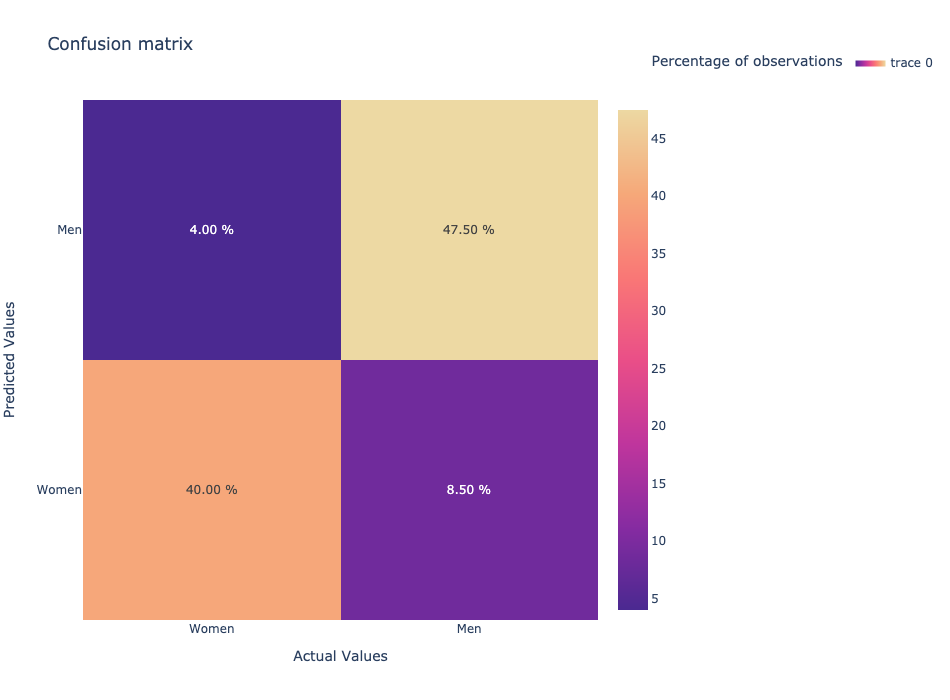

In [50]:
#Confusion matrix for adjectives
plot15 = plot_confusion_matrix_plotly(conf_mat_adj)
plot15.write_html("plot/plot15.html")
plot15.write_image("plot/plot15.png")
Image(filename='plot/plot15.png')

In [51]:
print('MOST DIFFERENCIATING FEATURES FOR  ADJECTIVES:')
for ctr,decade in enumerate(decades):   
    print(decade)
    print(differentiating_features_decades_adj[ctr])

MOST DIFFERENCIATING FEATURES FOR  ADJECTIVES:
1930-1940
['violence' 'feminine' 'negative_emotion' 'celebration' 'war' 'emotional'
 'prison' 'attractive' 'injury' 'positive_emotion']
1940-1950
['children' 'attractive' 'beauty' 'feminine' 'youth' 'ancient' 'family'
 'hate' 'emotional' 'appearance']
1950-1960
['youth' 'attractive' 'feminine' 'children' 'appearance' 'wealthy'
 'beauty' 'sexual' 'gain' 'swearing_terms']
1960-1970
['feminine' 'ocean' 'military' 'friends' 'achievement' 'sexual' 'health'
 'divine' 'wedding' 'heroic']
1970-1980
['beauty' 'feminine' 'attractive' 'children' 'medical_emergency' 'youth'
 'ancient' 'military' 'masculine' 'appearance']
1980-1990
['attractive' 'feminine' 'beauty' 'medical_emergency' 'crime' 'sexual'
 'competing' 'terrorism' 'horror' 'children']
1990-2000
['shape_and_size' 'children' 'clothing' 'monster' 'ancient' 'violence'
 'childish' 'competing' 'youth' 'kill']
2000-2010
['aggression' 'business' 'death' 'poor' 'ancient' 'children'
 'cheerfulness' '

Accuracy of classification with random forest (ADJECTIVES):
1930-1940 : 0.9725
1940-1950 : 1.0
1950-1960 : 0.9875
1960-1970 : 0.9925
1970-1980 : 0.985
1980-1990 : 0.9625
1990-2000 : 0.9875
2000-2010 : 0.875


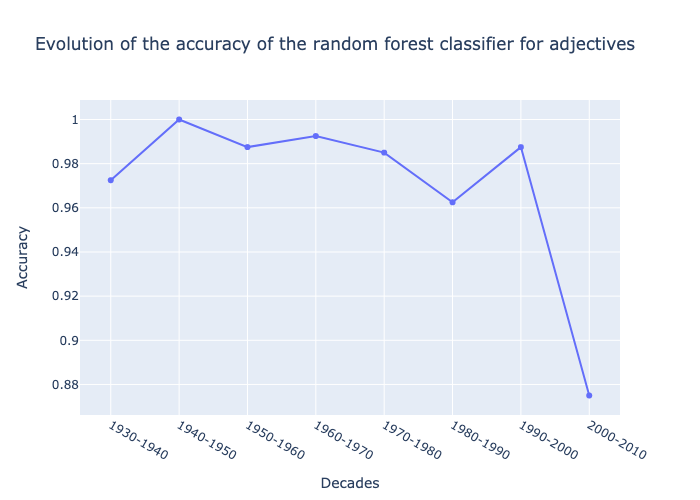

In [52]:
print('Accuracy of classification with random forest (ADJECTIVES):')
for ctr,decade in enumerate(decades):   
    print(decade,':',accuracy_decades_adj[ctr])

#Plot of the evolution of accuracy using adjectives
plot14 = px.line(x=decades, y=accuracy_decades_adj, title='Evolution of the accuracy of the random forest classifier for adjectives', markers=True)
plot14.update_layout(xaxis_title="Decades", yaxis_title="Accuracy")
plot14.write_html("plot/plot14.html")
plot14.write_image("plot/plot14.png")
Image(filename='plot/plot14.png')

##### Verbs

In [53]:
#Random forest for verbs
df_features_imp_verb, accuracy_decades_verb, differentiating_features_decades_verb, conf_mat_verb = random_forest_decades(df_decades, 50 , 1000, 'Verbs')
df_features_imp_verb

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0.008804,0.002227,0.003696,0.005394,0.011397,0.003160,0.004898,0.006090,0.004894,0.004749,...,0.013766,0.002745,0.000499,0.001322,0.020487,0.004665,0.003598,0.005082,0.010973,0.007569
1,0.007946,0.001254,0.002799,0.004960,0.019756,0.001767,0.003338,0.005443,0.003625,0.005340,...,0.007130,0.002900,0.000758,0.003019,0.017456,0.002659,0.004371,0.021928,0.014618,0.006988
2,0.007903,0.001624,0.003288,0.003890,0.011571,0.003425,0.003462,0.004571,0.003754,0.004761,...,0.037331,0.002195,0.001938,0.001582,0.011733,0.004813,0.003564,0.006169,0.009106,0.003560
3,0.004957,0.000369,0.001004,0.001686,0.025477,0.000226,0.003519,0.010573,0.008162,0.001947,...,0.002182,0.001218,0.000170,0.000267,0.057557,0.004868,0.001329,0.003942,0.024749,0.007546
4,0.008117,0.002156,0.003076,0.005783,0.007539,0.008596,0.003727,0.005514,0.003530,0.009193,...,0.030293,0.002357,0.001211,0.001442,0.011485,0.003071,0.002805,0.005382,0.009124,0.005145
5,0.007804,0.001794,0.003420,0.003452,0.009018,0.001794,0.012833,0.004695,0.004408,0.005134,...,0.006862,0.002857,0.001422,0.001056,0.017375,0.003783,0.002758,0.006533,0.010224,0.002677
6,0.010049,0.000493,0.003036,0.001534,0.008597,0.000498,0.002992,0.006448,0.001439,0.002684,...,0.003588,0.000854,0.000040,0.000298,0.041223,0.002174,0.002498,0.004168,0.009631,0.002767
7,0.009939,0.000613,0.002252,0.003383,0.012035,0.001598,0.003545,0.008272,0.002600,0.004511,...,0.005037,0.002802,0.000223,0.000463,0.023968,0.002281,0.002923,0.006759,0.011249,0.003846


/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:349: DeprecationWarning:

plotly.graph_objs.Legend is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Legend




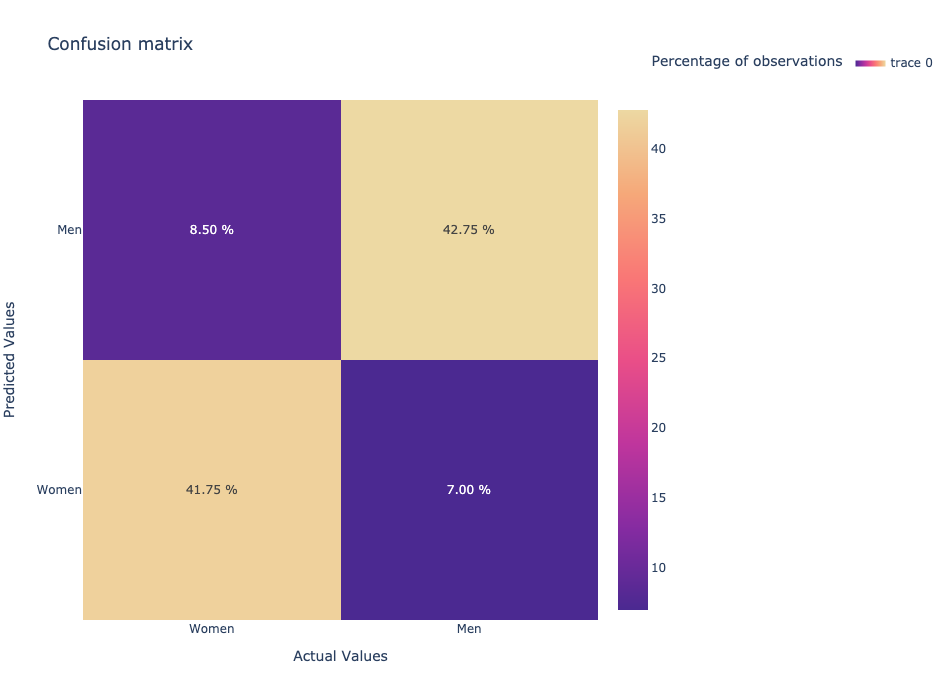

In [54]:
#Confusion matrix for verbs
plot16 = plot_confusion_matrix_plotly(conf_mat_verb)
plot16.write_html("plot/plot16.html")
plot16.write_image("plot/plot16.png")
Image(filename='plot/plot16.png')

In [55]:
print('MOST DIFFERENCIATING FEATURES FOR VERBS:')
for ctr,decade in enumerate(decades):   
    print(decade)
    print(differentiating_features_decades_verb[ctr])

MOST DIFFERENCIATING FEATURES FOR VERBS:
1930-1940
['communication' 'family' 'speaking' 'love' 'giving' 'meeting' 'traveling'
 'dispute' 'injury' 'pain']
1940-1950
['movement' 'love' 'affection' 'communication' 'rural' 'family' 'wedding'
 'home' 'meeting' 'speaking']
1950-1960
['movement' 'weapon' 'fight' 'meeting' 'friends' 'affection'
 'communication' 'traveling' 'celebration' 'war']
1960-1970
['speaking' 'traveling' 'giving' 'communication' 'family' 'movement'
 'dispute' 'order' 'meeting' 'deception']
1970-1980
['fight' 'weapon' 'restaurant' 'negative_emotion' 'love' 'sexual'
 'competing' 'family' 'driving' 'traveling']
1980-1990
['traveling' 'speaking' 'communication' 'party' 'order' 'movement'
 'optimism' 'love' 'family' 'pain']
1990-2000
['communication' 'speaking' 'traveling' 'movement' 'giving' 'order' 'pain'
 'meeting' 'negative_emotion' 'family']
2000-2010
['speaking' 'traveling' 'communication' 'movement' 'order' 'meeting'
 'giving' 'family' 'dispute' 'art']


Accuracy of classification with random forest (VERBS):
1930-1940 : 0.7325
1940-1950 : 0.78
1950-1960 : 0.83
1960-1970 : 0.985
1970-1980 : 0.74
1980-1990 : 0.8475
1990-2000 : 0.9725
2000-2010 : 0.845


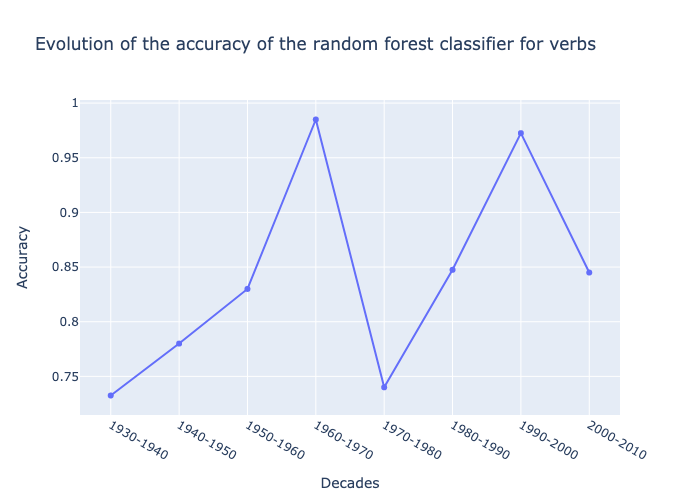

In [56]:
print('Accuracy of classification with random forest (VERBS):')
for ctr,decade in enumerate(decades):   
    print(decade,':',accuracy_decades_verb[ctr])

#Plot of the evolution of accuracy using adjectives
plot15 = px.line(x=decades, y=accuracy_decades_verb, title='Evolution of the accuracy of the random forest classifier for verbs', markers=True)
plot15.update_layout(xaxis_title="Decades", yaxis_title="Accuracy")
plot15.write_html("plot/plot15.html")
plot15.write_image("plot/plot15.png")
Image(filename='plot/plot15.png')

What we observe:
- More difficult to classify using verbs than adjectives
- Adjectives: the accuracy decreases when advancing through the decades
- Verbs: no particular increasing or decreasing trend

##### Evolution of lexical fields

We want to see the evolution of some features in their ability to diferenciate male and female character. To do that, we plot the evolution through decades of the feature importance score (from random forest).

In [57]:
###Plot evolution of some features lexical fields

def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
    '''Returns a seaborn palette reordered by value
    Parameters:
    values: pd.Series
    palette_name:str, Seaborn valid palette name
    ascending: bool, optional color sort order
    '''
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

def barplot_differentiating_features(df,decades,pos,features):
    '''Plot the evolution of selected feature importance 
    Parameters:
    df: pd.Series
    decades:str, 
    pos: str, part of speech (adjective or verb)
    features: str, selected features to plot
    '''
    #Initialization of the figure
    fig, ax = plt.subplots(2,2,figsize= (30,15))
    palette.reverse()

    #Plot the different features
    for ctr,lex_field in enumerate(features):
        sbplt = ax[math.floor(ctr/2),ctr%2]
        sns.barplot(data=df, x=decades, y=lex_field, ax=sbplt, palette=colors_from_values(df[lex_field], "YlOrBr"))
        sbplt.set_title(lex_field,  fontsize=30)
        sbplt.set_ylabel('Lexical importance')
    fig.suptitle(pos,fontsize=40)
    plt.show()


In [58]:
#Adjectives
#features = ['appearance','love','attractive','beauty']
#barplot_differentiating_features(df_features_imp_adj,decades,'Adjectives',features)

In [59]:
#Verbs
#features = ['domestic_work','love','affection','beauty']
#barplot_differentiating_features(df_features_imp_verb,decades,'Verbs',features)

#### Principal Component Analysis

The goal of performing a Principal Component Analysis is to reduce the dimensionality of the data, which can be useful when working with large datasets or when dealing with data that has many variables that are correlated with each other. By identifying the most important directions in which the data vary, PCA can help to reduce the number of variables that need to be considered, which can make it easier to analyze the data. In this way, we could reduce the data to a two-dimensional space and see how male and female associated words are located in this space. By analyzing the distance between male and female points, one could determine the difficulty of differentiating between them.

In [60]:
#Display the most differentiating features on all decades
differentiating_features_adj = list(set(sum([list(feature) for feature in differentiating_features_decades_adj],[])))
print(differentiating_features_decades_adj,len(differentiating_features_decades_adj))
differentiating_features_verb= list(set(sum([list(feature) for feature in differentiating_features_decades_verb],[])))
print(differentiating_features_decades_verb,len(differentiating_features_decades_verb))


[array(['violence', 'feminine', 'negative_emotion', 'celebration', 'war',
       'emotional', 'prison', 'attractive', 'injury', 'positive_emotion'],
      dtype=object), array(['children', 'attractive', 'beauty', 'feminine', 'youth', 'ancient',
       'family', 'hate', 'emotional', 'appearance'], dtype=object), array(['youth', 'attractive', 'feminine', 'children', 'appearance',
       'wealthy', 'beauty', 'sexual', 'gain', 'swearing_terms'],
      dtype=object), array(['feminine', 'ocean', 'military', 'friends', 'achievement',
       'sexual', 'health', 'divine', 'wedding', 'heroic'], dtype=object), array(['beauty', 'feminine', 'attractive', 'children',
       'medical_emergency', 'youth', 'ancient', 'military', 'masculine',
       'appearance'], dtype=object), array(['attractive', 'feminine', 'beauty', 'medical_emergency', 'crime',
       'sexual', 'competing', 'terrorism', 'horror', 'children'],
      dtype=object), array(['shape_and_size', 'children', 'clothing', 'monster', 'ancient

In [61]:

def pca_plotly(df,pos,differentiating_features,name):
    '''Perform a Principal Component Analysis and plot the results in a 2d space, across the decades
    Parameters:
    df: pd.Series
    pos: str, part of speech (adjective or verb)
    important_features: str, ?? most differentiating features (on all decades)
    '''

    # Selecting vector of reduced dimensions corresponding to the most differentiating features selected
    Xd = pd.DataFrame(np.zeros((16,len(differentiating_features))))
    for i in range(16):
        Xd.iloc[i] = df.loc[i , differentiating_features]
     
    # PCA to reduce the dimensions to 2d space 
    pca = PCA(n_components=2)
    X2d = pca.fit_transform(Xd)

    # Percentage of explained variance for each principal component
    pca = PCA(n_components=2).fit(Xd)
    exp_var_pca = pca.explained_variance_ratio_

    #Dataframe for plotly scatter plot
    df_plot = pd.DataFrame()
    df_plot['x'] = X2d[:,0]
    df_plot['y'] = X2d[:,1]
    df_plot['Decade'] = df['Decade']
    df_plot['Decades'] = np.repeat(decades, 2)
    df_plot['Gender'] = df['Actor_gender']

    #Dynamic plotly scatter plot
    fig = px.scatter(df_plot, x='x', y='y', animation_frame='Decades',
            color="Gender", range_x=[min(df_plot['x'])-0.02,max(df_plot['x'])+0.02], range_y=[min(df_plot['y'])-0.02,max(df_plot['y'])+0.02] )
    fig.update_traces(marker={'size': 30})
    fig.update_layout(
        title="PCA 2D projection of 10 most important features per decade for "+pos,
        xaxis_title='Principal Component 1 ({:.2%})'.format(exp_var_pca[0]),
        yaxis_title='Principal Component 2 ({:.2%})'.format(exp_var_pca[1]),
        legend_title="Gender")
    fig.write_html('plot/plot'+name+'.html')
    fig.write_image('plot/plot'+name+'.png')

    #Evolution of the distances between the points M and F in 2-dimensional space
    distances=[]
    for i in range(0,len(X2d),2):
        distances.append(np.linalg.norm(X2d[i]-X2d[i+1]))
    
    fig2  = px.line(x=decades, y=distances, title='Distance', markers=True, labels={'x':'Decades', 'y':'Distance in 2D space'})
    fig2.update_layout(title='Distance between male and female points')
    fig2.write_html('plot/plot'+name+'_distances.html')
    fig2.write_image('plot/plot'+name+'_distances.png')



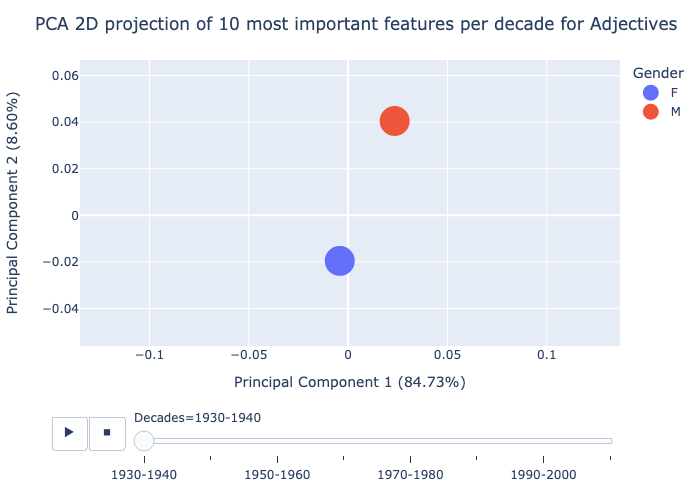

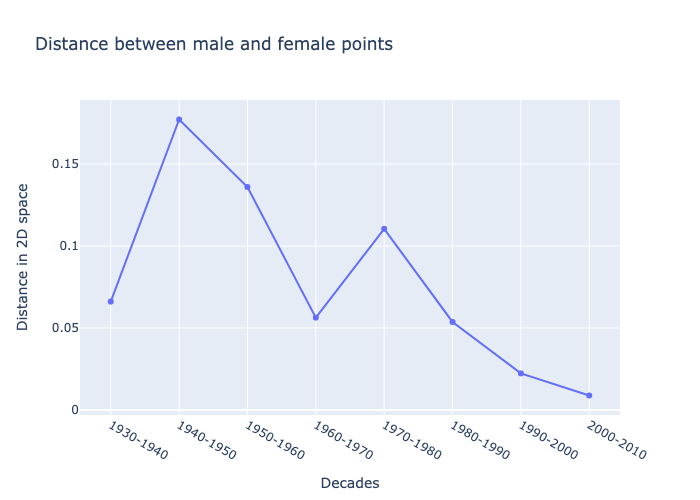

In [62]:
#Adjectives
name = 'PCA_adjectives'
pca_plotly(df_lex_adj,'Adjectives',differentiating_features_adj,name)
listOfImageNames = ['plot/plot'+name+'.png',
                    'plot/plot'+name+'_distances.png']
for imageName in listOfImageNames:
    display(Image(filename=imageName))

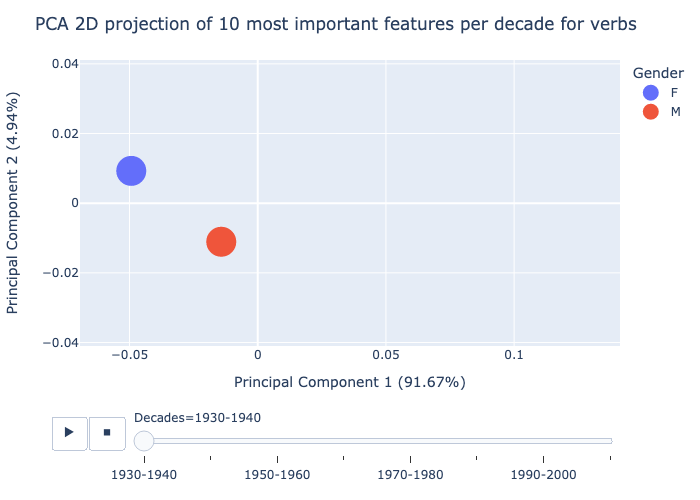

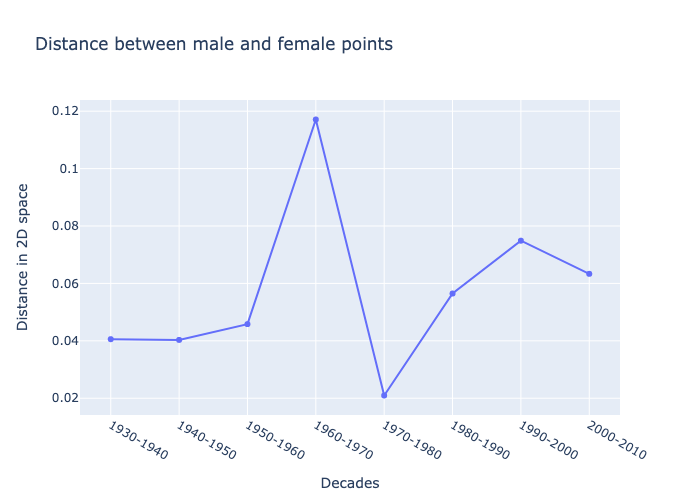

In [63]:
#Verbs
name = 'PCA_verbs'
pca_plotly(df_lex_verb,'verbs',differentiating_features_verb,name)
listOfImageNames = ['plot/plot'+name+'.png',
                    'plot/plot'+name+'_distances.png']
for imageName in listOfImageNames:
    display(Image(filename=imageName))